
    down trans_up       up 
     797      699     1848 

[1] "#A6CEE3" "#1F78B4" "#B2DF8A" "#33A02C" "#FB9A99"

Warning message:
“Since you have set `order`, you should better set `grid.col` as a named
vector where sector names are the vector names, or else the color will
be wrongly assigned.”
Warning message:
“Since you have set `group`, you should better set `grid.col` as a named
vector where sector names are the vector names, or else the color will
be wrongly assigned.”
Note: 1 point is out of plotting region in sector 'Braindown', track
'1'.

Note: 1 point is out of plotting region in sector 'Braindown', track
'1'.

Note: 9 points are out of plotting region in sector 'Braindown', track
'1'.

Note: 1 point is out of plotting region in sector 'Braintrans_down',
track '1'.

Note: 1 point is out of plotting region in sector 'Braintrans_down',
track '1'.

Note: 15 points are out of plotting region in sector 'Braintrans_down',
track '1'.

Note: 1 point is out of plotting region in sector 'Brainup', track '1'.

Note: 1 point is out of plotting region in sector 'Brainup', track '1'.

Note: 7 points 

pdf 
  2

null device 
          1

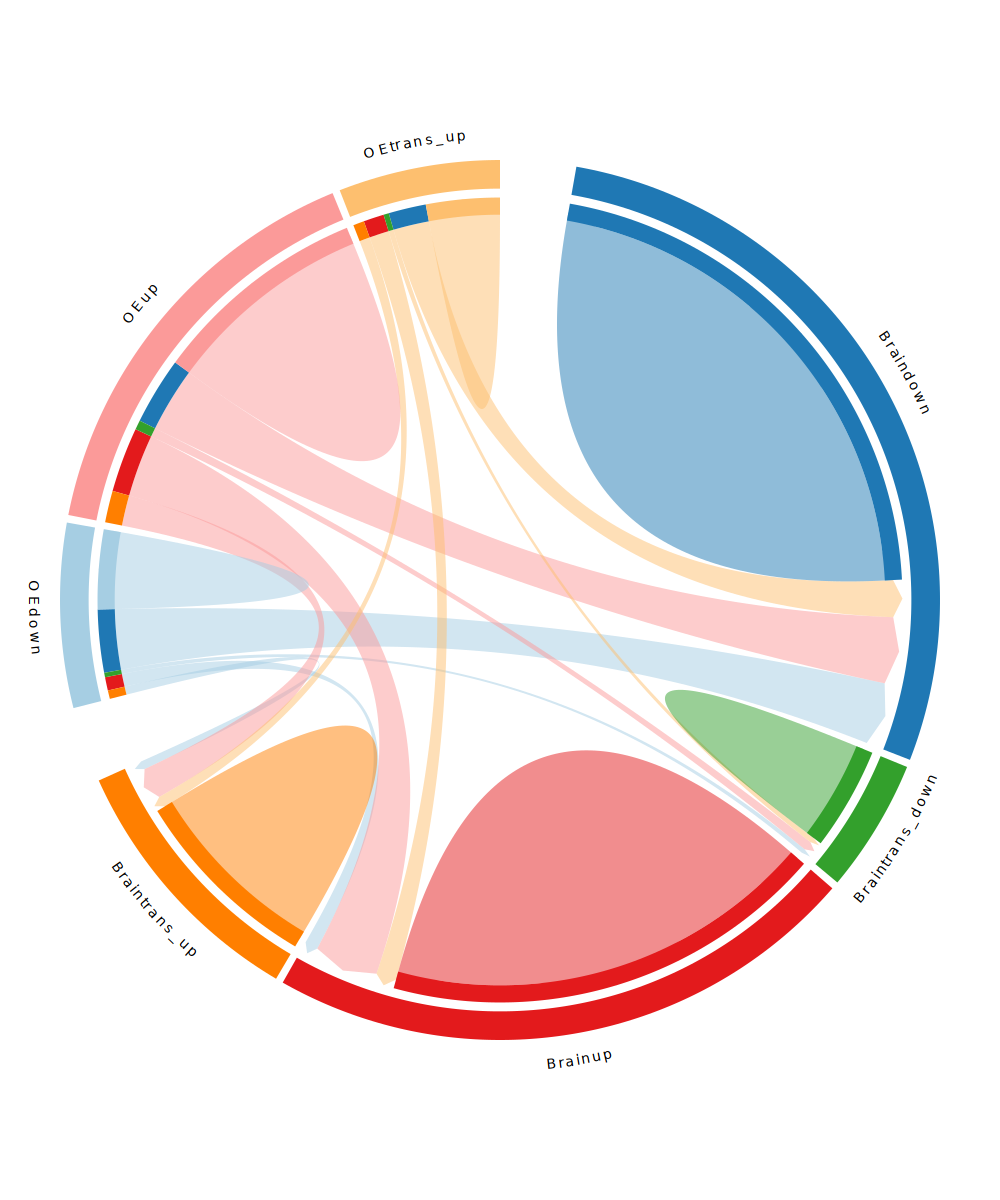

In [18]:
library(stringr)
library(gprofiler2)
library(rrvgo)
library(ggplot2)

options(repr.plot.width = 10, repr.plot.height = 12, repr.plot.res = 100)


dev_files <- list.files('/sc/arion/projects/roussp01a/liting/Olf/data/lister_devDEG/', '.txt')
dev_gs <- c()
for(fl in dev_files){
  dev_g <- read.table(paste0('/sc/arion/projects/roussp01a/liting/Olf/data/lister_devDEG/',fl),header = T)
  cell_type <- gsub('\\.txt|-','',fl)
  dev_g$celltype <- cell_type
  dev_gs <- rbind(dev_g,dev_gs)
}

dev_gs <- subset(dev_gs, !grepl('^MT|^LINC|^MIR|^RP',gene_name ) & celltype=="L23_CUX2")

#num_devG_trend <- lapply( split(dev_gs,dev_gs$trend_class), function(x) table(x$gene_name))

# consensus DEGs across cell types in each trend
down_brain <- subset(dev_gs, trend_class=='down')[,"gene_name"]
up_brain <- subset(dev_gs, trend_class=='up')[,"gene_name"]
trans_down_brain <- subset(dev_gs, trend_class=='trans_down')[,"gene_name"]
trans_up_brain <- subset(dev_gs, trend_class=='trans_up')[,"gene_name"]

DEG_trend_Brain <- list(down=down_brain, 
                        up=up_brain, 
                        trans_down=trans_down_brain, 
                        trans_up=trans_up_brain)


# OLF devDEGs
#load('/sc/arion/projects/roussp01a/liting/Olf/data/DEG_trend_Olf_k6.RData')
load('/sc/arion/projects/roussp01a/liting/Olf/data/DEG_trend_Olf_k7_graph2.RData')
table(DEG_trend_Olf$trend_class)

# format DEG_overlap_gene[trend_Olf][trend_Brain]
DEG_overlap_gene <- list()
for (t1 in c('down','up','trans_down','trans_up')){
  DEG_overlap_gene[[t1]] <- lapply(DEG_trend_Brain, function(x) intersect( x, DEG_trend_Olf$gene[DEG_trend_Olf$trend_class==t1]) )
}


n_DEG_overlap_gene <- as.data.frame(unlist(lapply(DEG_overlap_gene, function(x) lapply(x, length) )))
n_DEG_overlap_gene <- cbind(n_DEG_overlap_gene, str_split( rownames(n_DEG_overlap_gene),'\\.',simplify = T))
colnames(n_DEG_overlap_gene) <- c('n','Olf_trend','Brain_trend')
n_DEG_overlap_gene$Olf_trend <- paste0('OE',n_DEG_overlap_gene$Olf_trend)
n_DEG_overlap_gene$Brain_trend <- paste0('Brain',n_DEG_overlap_gene$Brain_trend)

unique_olf <- table((subset(DEG_trend_Olf,!gene%in% unlist(DEG_trend_Brain)))$trend_class)
unique_brain <- sapply(DEG_trend_Brain, function(x) length(setdiff(x, DEG_trend_Olf$gene)))

uniq_genes <- as.data.frame(rbind(
  cbind(
    unique_olf,
    paste0('OE', names(unique_olf) ),
    paste0('OE',  names(unique_olf) )
  ),
  cbind(
    unique_brain,
    paste0('Brain', names(unique_brain) ) ,
    paste0('Brain', names(unique_brain) ) 
  )))
colnames(uniq_genes) <- c('n','Olf_trend','Brain_trend')

n_cicle_DE <- rbind(n_DEG_overlap_gene, uniq_genes)

n_cicle_DE$n <- as.numeric(n_cicle_DE$n)

# ggplot(n_DEG_overlap_gene, aes(x=Olf_trend,y=Brain_trend))+
#   geom_tile(aes(fill = n))
library(circlize)

library(RColorBrewer)
brewer.pal(n = 5, name = "Paired")


col_fun = colorRamp2(seq(1,300,50), rev(brewer.pal(6, "RdBu")))
#col <- ifelse(n_cicle_DE$Olf_trend!=n_cicle_DE$Brain_trend,col_fun(n_cicle_DE$n), "#FFFFFF00")

library(RColorBrewer)
circos.par(start.degree = 80)
nm = c(paste0(c("OE"), c('down','trans_down','up','trans_up')), paste0(c("Brain"), c('down','trans_down','up','trans_up')))
group = structure(c(rep('OE',4),rep('Brain',4)), names = nm)

chordDiagram(n_cicle_DE[,c(2,3,1)], self.link = 1, 
             order = nm,
             grid.col = brewer.pal(n = 8, name = "Paired")[c(1,3,5,7,2,4,6,8)],
             #col=col, 
             annotationTrack = c("grid"),
             annotationTrackHeight = mm_h(5) ,
             diffHeight = mm_h(3), target.prop.height = mm_h(5),
             directional = 1, direction.type = c("diffHeight", "arrows"), 
             link.arr.type = "big.arrow",
             group = group,
             big.gap = 10)

for(si in get.all.sector.index()) {
  xlim = get.cell.meta.data("xlim", sector.index = si, track.index = 1)
  ylim = get.cell.meta.data("ylim", sector.index = si, track.index = 1)
  circos.text(mean(xlim), 2, si, sector.index = si, track.index = 1, cex = 0.8,
              facing = "bending.inside", niceFacing = TRUE, col = "black")
}
circos.clear()
#draw(x = unit(0.82, "npc"), y = unit(0.6, "npc"),just="left",Legend(col_fun = col_fun, title = "Number of links"))
dev.print(pdf, file='./figures/devdeg_overlap.pdf')
dev.off()



In [19]:
load('./data/custom_olfbg.RData')
load('./data/lister_brain_bg.RData')
overlap_bg <- intersect(brain_bg,custom_olfbg )

In [3]:

# dbs <- "GO_Biological_Process_2023"
# enrichr(DEG_overlap_gene[['up']][['down']], dbs)[['GO_Biological_Process_2023']]


### enriched pathway of different gene sets

In [3]:
# overlappped gene pathway enrichment

get_bp <- function(olf_trend, brain_trend){
  enrr <- c()
  query_gene <- DEG_overlap_gene[[olf_trend]][[brain_trend]]
  
  if (length(query_gene)>20){
    enriched <- gost(query_gene,source='GO:BP',correction_method = "fdr",custom_bg = overlap_bg,user_threshold=0.1,significant=F)
    enrr <- enriched$result %>%subset(term_size < 2000)
    
    enrr$olf_trend <- olf_trend
    enrr$brain_trend <- brain_trend
    
  }
  return(enrr) 
}

gobps_devDEG <- c()
for (olf_trend in c('up','down','trans_up','trans_down')){
  for(brain_trend in c('up','down','trans_up','trans_down')){
    gobp_devDEG <- get_bp(olf_trend, brain_trend)
    gobps_devDEG <- rbind(gobps_devDEG, gobp_devDEG)
  }
}

# brain unique gene
unique_brain <- sapply(DEG_trend_Brain, function(x) setdiff(x, DEG_trend_Olf$gene))

unique_brain_gobp <- lapply(unique_brain, function(x) {df <-    gost(x, source='GO:BP',custom_bg = brain_bg,  correction_method = "fdr",user_threshold=0.1,significant=F)$result %>%subset(term_size < 2000)  } )
                       
unique_brain_gobps <- do.call(rbind,unique_brain_gobp)
unique_brain_gobps$brain_trend <- str_split(rownames(unique_brain_gobps),pattern = '\\.',simplify = T)[,1]

# olf unique gene
unique_olf <- subset(DEG_trend_Olf,!gene%in% unlist(DEG_trend_Brain))
unique_olf <- split(unique_olf$gene,unique_olf$trend_class)
unique_olf_gobp <- lapply(unique_olf, function(x) {df <-    gost(x, source='GO:BP', custom_bg = custom_olfbg, correction_method = "fdr",user_threshold=0.1,significant=F)$result %>%subset(term_size < 2000)  } )

unique_olf_gobps <- do.call(rbind,unique_olf_gobp)
unique_olf_gobps$olf_trend <- str_split(rownames(unique_olf_gobps),pattern = '\\.',simplify = T)[,1]


Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope i

### plot enriched gobp

Warning message:
“package ‘dplyr’ was built under R version 4.3.2”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




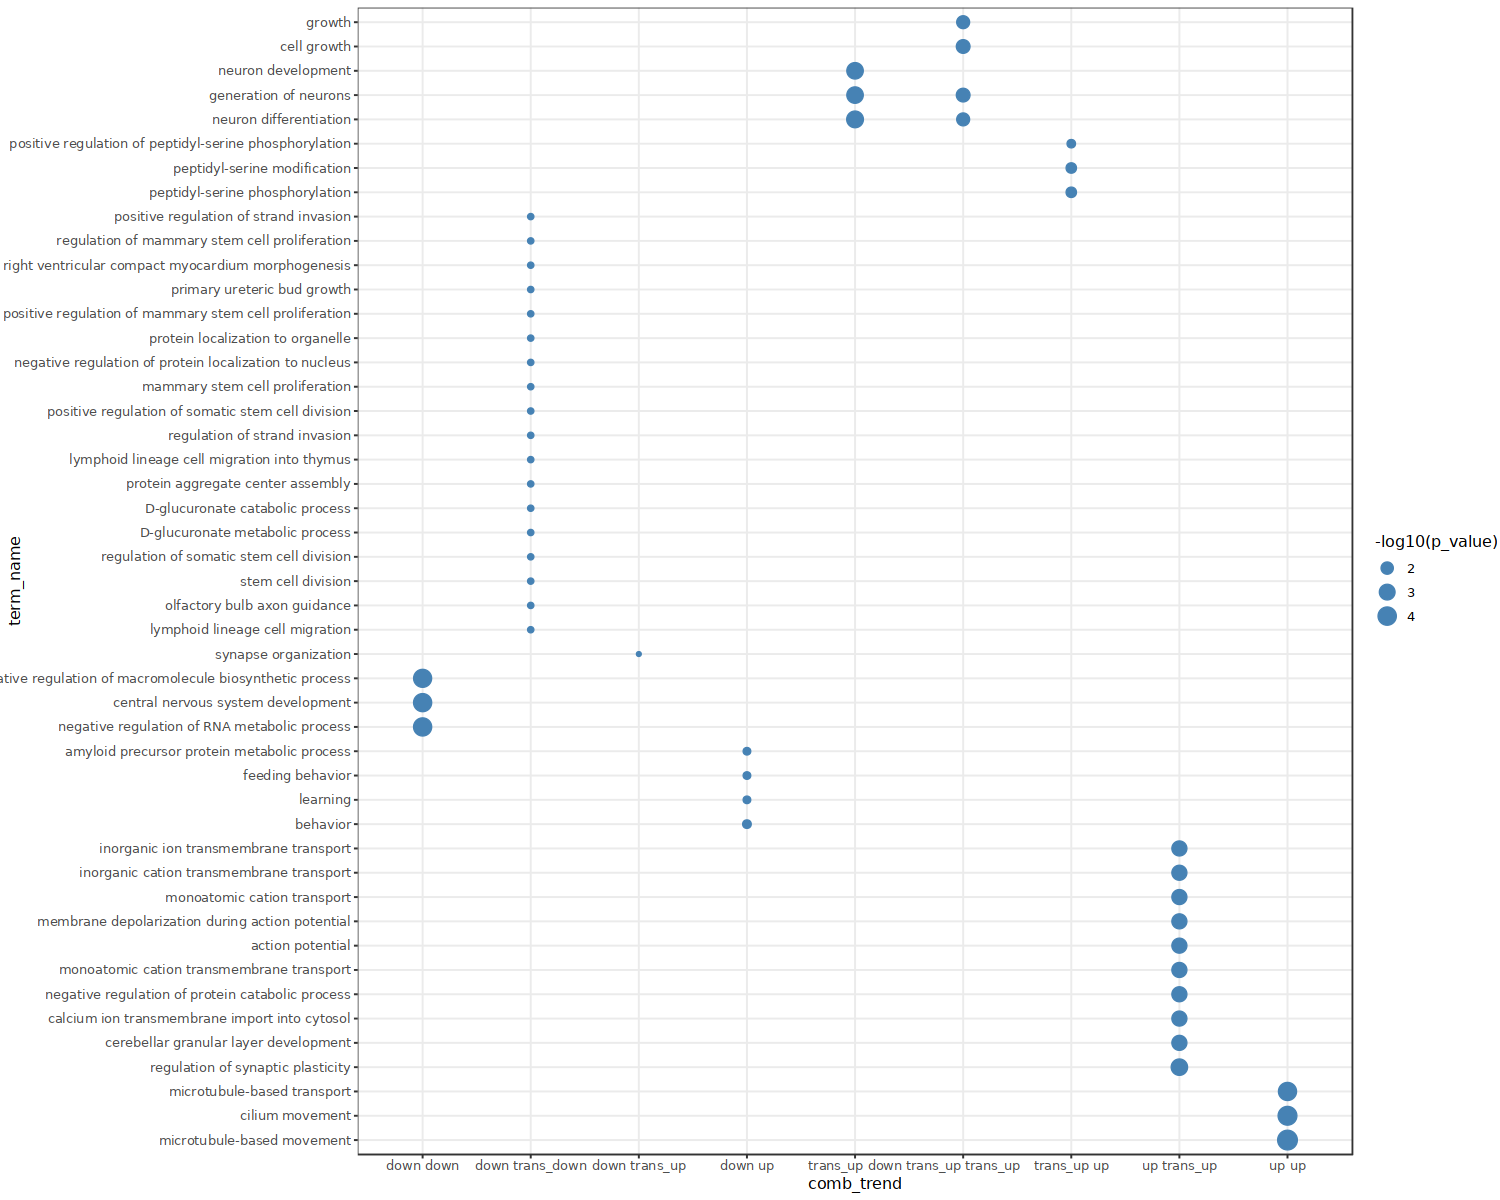

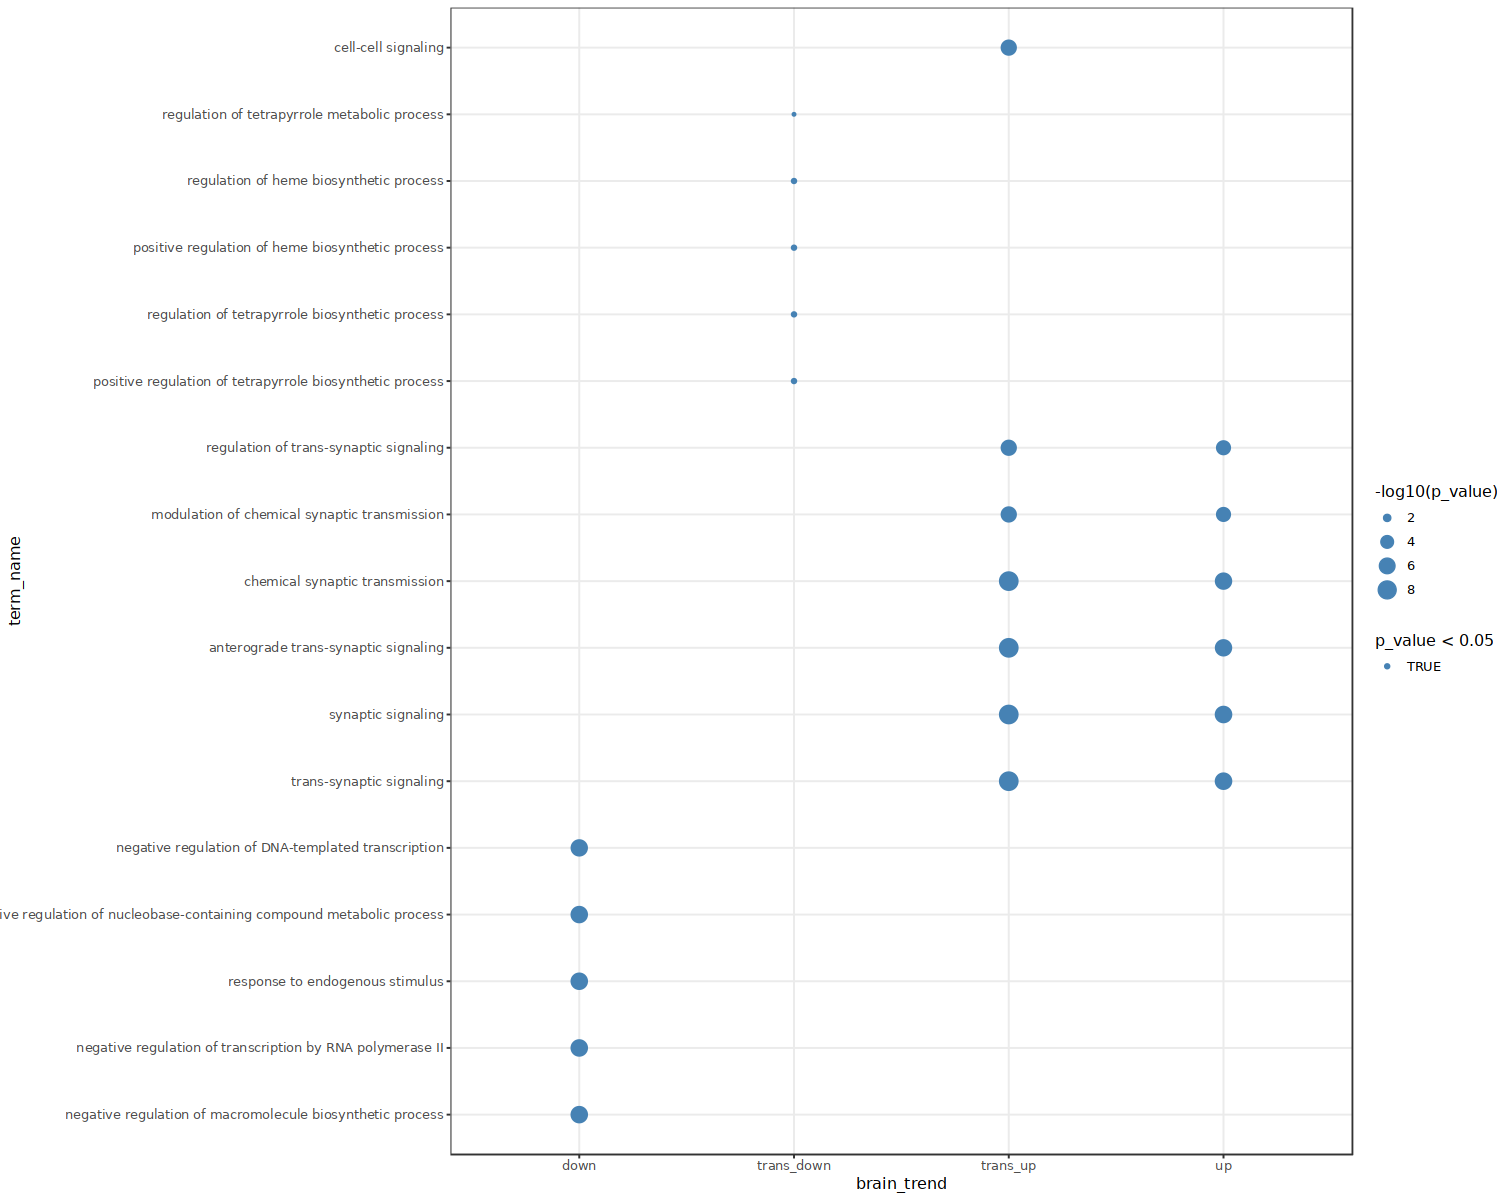

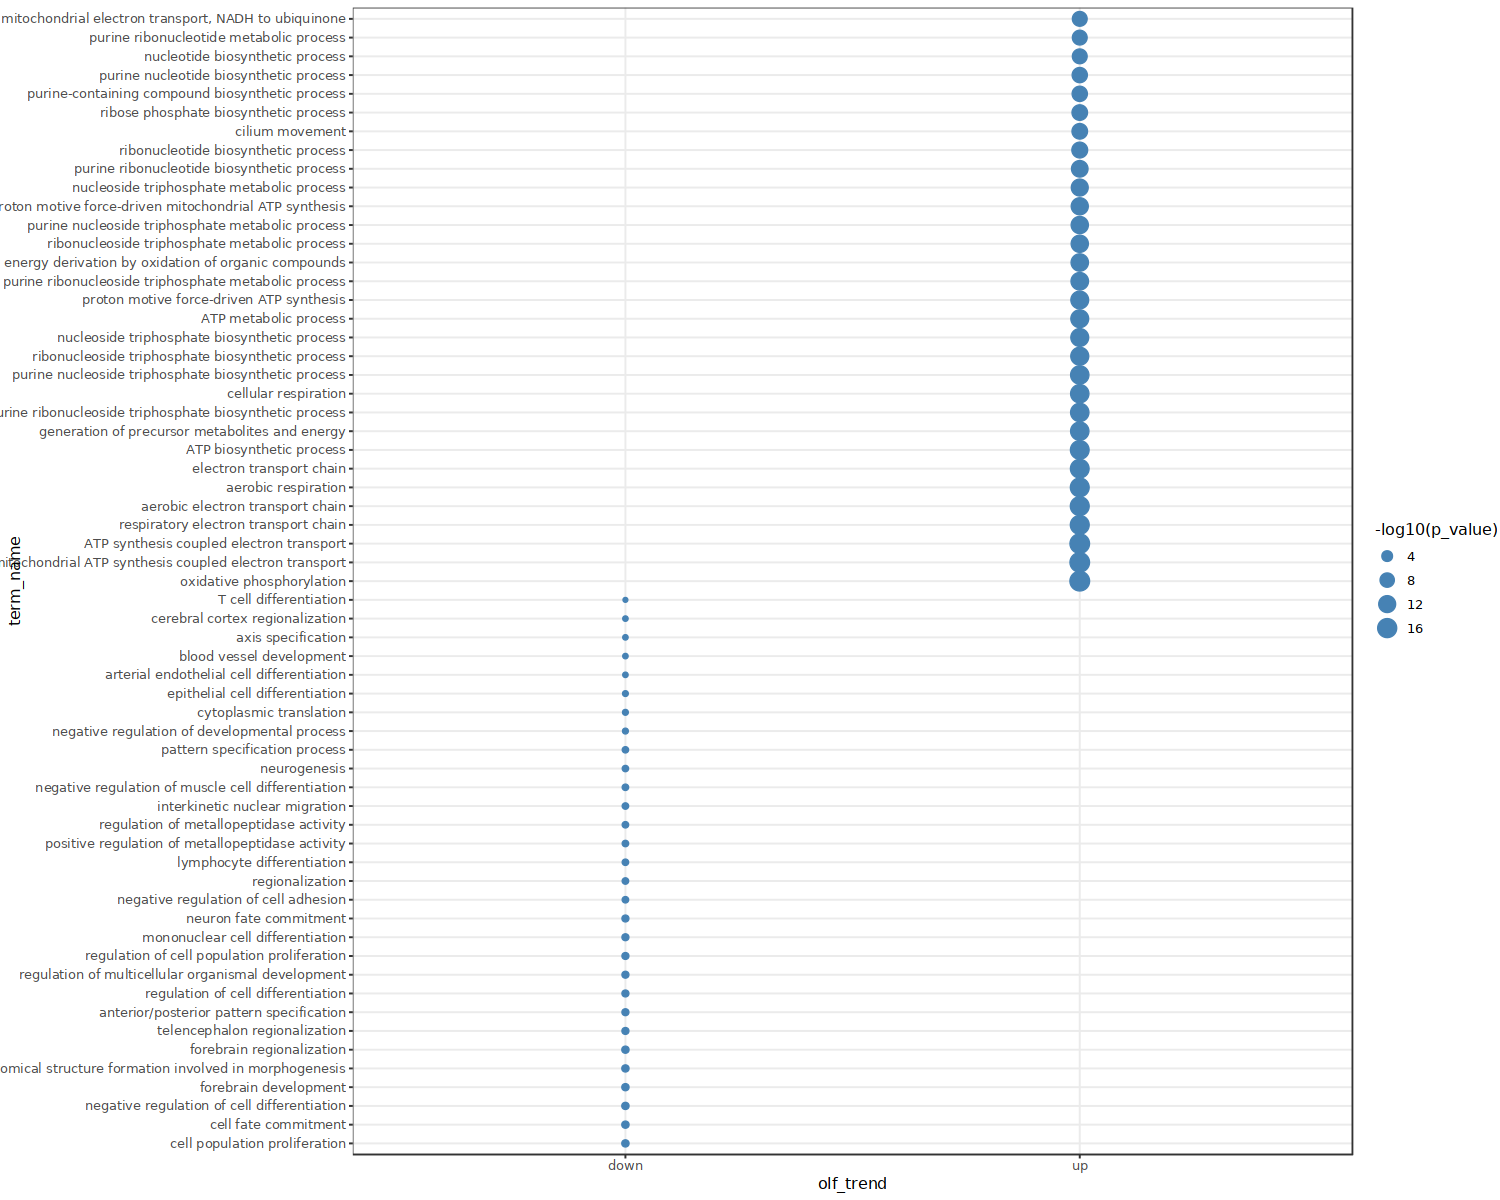

In [4]:
library(ggplot2)
# overlappped
options(repr.plot.width = 15, repr.plot.height = 12, repr.plot.res = 100)

library(dplyr)
gobps_devDEG_sig <- subset(gobps_devDEG, p_value < 0.1)
gobps_devDEG_sig$comb_trend <- paste(gobps_devDEG_sig$olf_trend, gobps_devDEG_sig$brain_trend)
gobps_devDEG_sig <- gobps_devDEG_sig%>%group_by(comb_trend)%>%top_n(3, -p_value)
gobps_devDEG_sig$term_name <- factor(gobps_devDEG_sig$term_name, levels=unique(gobps_devDEG_sig$term_name))
ggplot(gobps_devDEG_sig, aes(x=comb_trend,y=term_name,size=-log10(p_value)))+geom_point(color='steelblue')+theme_bw()


# brain unique

gobps_brain_sig <- subset(unique_brain_gobps, p_value < 0.05)

gobps_brain_sig <- gobps_brain_sig%>%group_by(brain_trend)%>%top_n(5, -p_value)
gobps_brain_sig$term_name <- factor(gobps_brain_sig$term_name, levels=unique(gobps_brain_sig$term_name))
ggplot(gobps_brain_sig, aes(x=brain_trend,y=term_name,size=-log10(p_value)))+geom_point(aes(shape=p_value < 0.05),color='steelblue')+theme_bw()

# olf unique

gobps_olf_sig <- subset(unique_olf_gobps, p_value < 0.05)
gobps_olf_sig <- gobps_olf_sig%>%group_by(olf_trend)%>%top_n(30, -p_value)
gobps_olf_sig$term_name <- factor(gobps_olf_sig$term_name, levels=unique(gobps_olf_sig$term_name))
ggplot(gobps_olf_sig, aes(x=olf_trend,y=term_name,size=-log10(p_value)))+geom_point(color='steelblue')+theme_bw()



### Neuron system associated BPs

In [5]:
enrrs_neuro <- subset(gobps_devDEG_sig,grepl('Neur|dendrite|synap|axon |Wnt|cilium| Ion |Nervous|axonogenesis|Stem cell',term_name,ignore.case = T))
go_term_sel <- enrrs_neuro%>%group_by(comb_trend)%>%top_n(5,-p_value)
go_term_sel$term <- str_split(go_term_sel$term_name,pattern = ' \\(',simplify = T)[,1]
go_term_sel <- aggregate(term~comb_trend,go_term_sel,'paste')
go_term_sel$term
go_term_sel$comb_trend

[[1]]
[1] "central nervous system development"

[[2]]
[1] "olfactory bulb axon guidance"                          
[2] "stem cell division"                                    
[3] "regulation of somatic stem cell division"              
[4] "positive regulation of somatic stem cell division"     
[5] "mammary stem cell proliferation"                       
[6] "positive regulation of mammary stem cell proliferation"
[7] "regulation of mammary stem cell proliferation"         

[[3]]
[1] "synapse organization"

[[4]]
[1] "neuron differentiation" "generation of neurons"  "neuron development"    

[[5]]
[1] "generation of neurons"  "neuron differentiation"

[[6]]
[1] "regulation of synaptic plasticity"            
[2] "calcium ion transmembrane import into cytosol"
[3] "inorganic ion transmembrane transport"        

[[7]]
[1] "cilium movement"

[1] "down down"         "down trans_down"   "down trans_up"    
[4] "trans_up down"     "trans_up trans_up" "up trans_up"      
[7] "up up"

In [467]:
enrrs_neuro <- subset(gobps_brain_sig,grepl('Neur|dendrite|synap|axon |Wnt|cilium| Ion |Nervous|axonogenesis|Stem cell', term_name,ignore.case = T))
go_term_sel <- enrrs_neuro%>%group_by(brain_trend)%>%top_n(5,-p_value)
go_term_sel$term <- str_split(go_term_sel$term_name,pattern = ' \\(',simplify = T)[,1]
go_term_sel <- aggregate(term~brain_trend,go_term_sel,'paste')
go_term_sel
go_term_sel$term
go_term_sel$brain_trend

brain_trend term        
1 trans_up    chemical....
2 up          synaptic....

[[1]]
[1] "chemical synaptic transmission"      
[2] "trans-synaptic signaling"            
[3] "synaptic signaling"                  
[4] "anterograde trans-synaptic signaling"

[[2]]
[1] "synaptic signaling"                          
[2] "trans-synaptic signaling"                    
[3] "anterograde trans-synaptic signaling"        
[4] "chemical synaptic transmission"              
[5] "modulation of chemical synaptic transmission"
[6] "regulation of trans-synaptic signaling"

[1] "trans_up" "up"

In [468]:
enrrs_neuro <- subset(unique_olf_gobps,grepl('Neur|dendrite|synap|axon |Wnt|cilium| Ion |Nervous|axonogenesis|Stem cell', term_name,ignore.case = T))
go_term_sel <- enrrs_neuro%>%group_by(olf_trend)%>%top_n(5,-p_value)
go_term_sel$term <- str_split(go_term_sel$term_name,pattern = ' \\(',simplify = T)[,1]
go_term_sel <- aggregate(term~olf_trend,go_term_sel,'paste')
# go_term_sel
# go_term_sel$term
# go_term_sel$olf_trend

Adding missing grouping variables: `comb_trend`


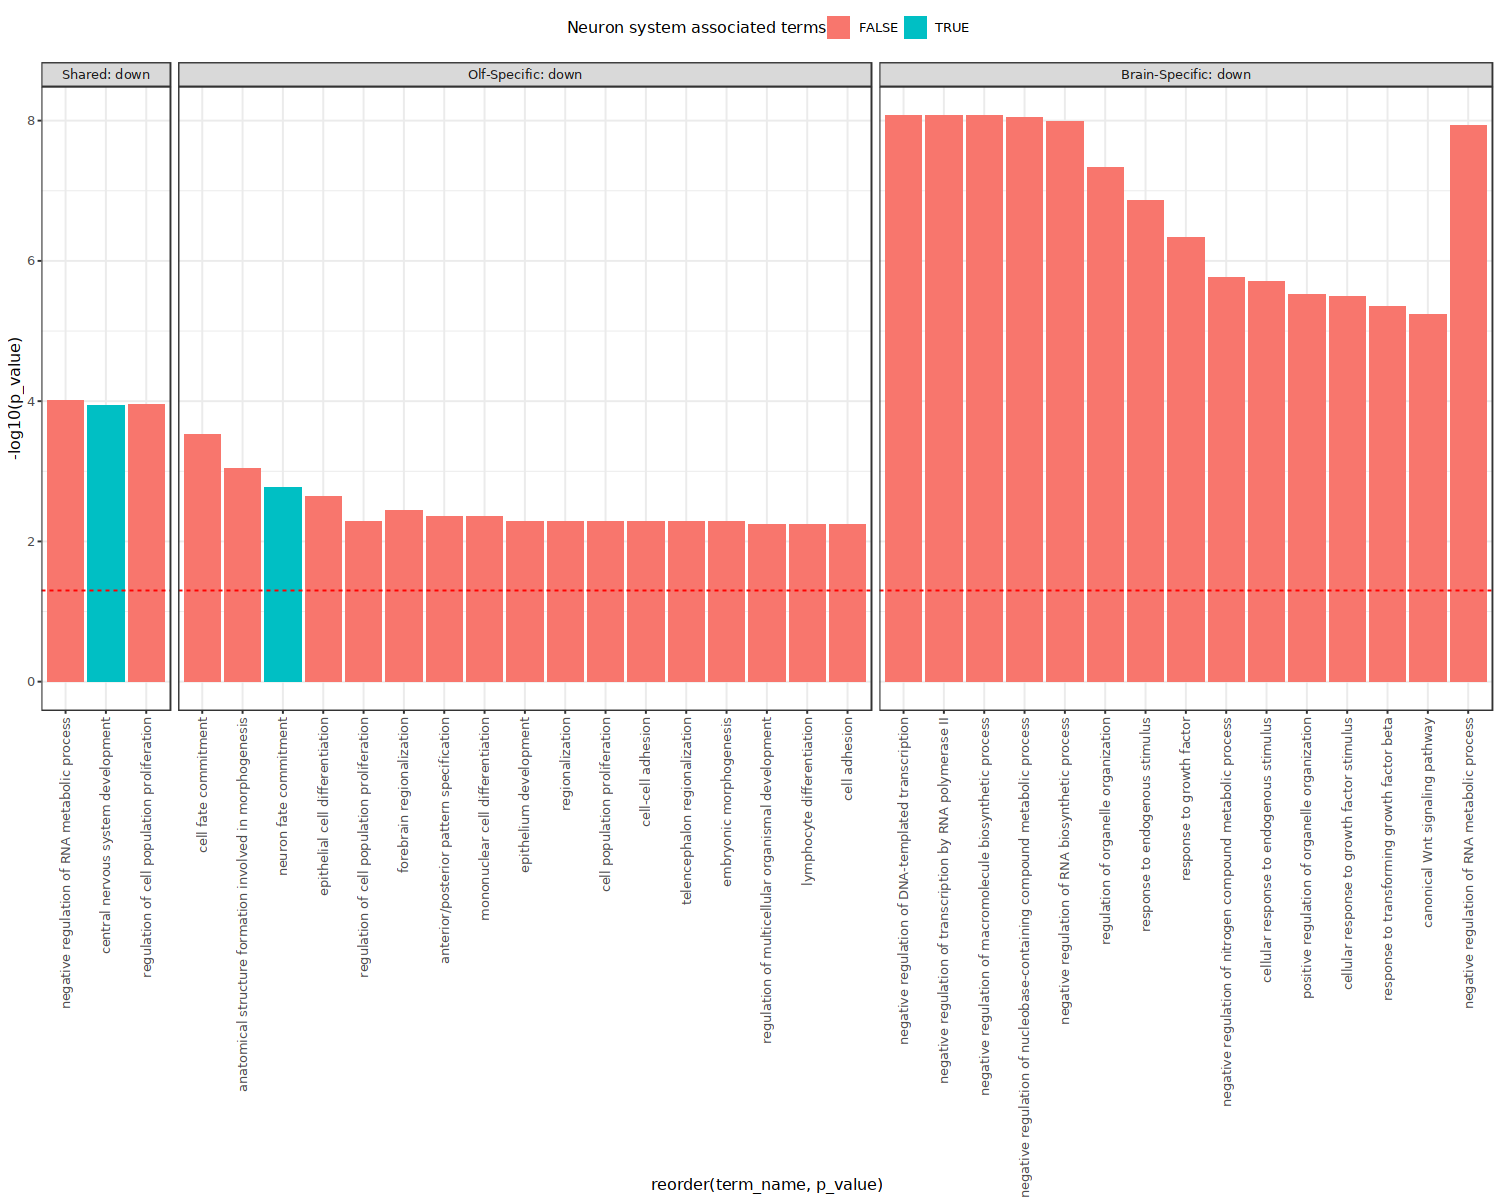

In [469]:
combined_gobp <- rbind(gobps_devDEG_sig%>% mutate(trend = paste0('Shared: ',comb_trend))%>% select(!c(olf_trend, brain_trend,comb_trend)) ,
unique_olf_gobps%>%mutate(trend = paste0('Olf-Specific: ',olf_trend))%>% select(!c(olf_trend)) ,
unique_brain_gobps%>%mutate(trend = paste0('Brain-Specific: ',brain_trend))%>% select(!c(brain_trend)) )%>%group_by(trend)%>%top_n(15, -p_value)
combined_gobp <- subset(combined_gobp, grepl(': down$|: down down',trend))
#combined_gobp$term <- str_split(combined_gobp$Term,pattern = '\\(',simplify = T)[,1]
combined_gobp$term_name <- factor(combined_gobp$term_name, levels = unique(combined_gobp$term_name))
combined_gobp$trend <- gsub('down down','down',combined_gobp$trend)
combined_gobp$trend <- factor(combined_gobp$trend, unique(combined_gobp$trend))

ggplot(combined_gobp, aes(x=reorder(term_name,p_value),y=-log10(p_value), 
                          fill=grepl('Neur|dendrite|synap|axon |cilium| Ion |Nervous|axonogenesis|Stem cell|projection', term_name, ignore.case = T)))+
guides(fill=guide_legend(title="Neuron system associated terms"))+
geom_bar(stat = 'identity')+facet_grid(~trend,scales = 'free_x',space = 'free')+theme_bw()+
theme(legend.position = 'top', axis.text.x = element_text(angle = 90,hjust = 1,vjust = 0.5))+
 geom_hline(yintercept=-log10(0.05), linetype="dashed", 
                color = "red", size=0.5)

#dev.print(pdf, file='./figures/enriched_term_overlap_gene_down.pdf',width=10, height=10)
# ggplot(combined_gobp, aes(x=term,y=-log10(p_value), 
#                           fill=grepl('Neur|dendrite|synap|axon |cilium| Ion |Nervous|axonogenesis|Stem cell|projection',term, Term,ignore.case = T)))+
# geom_bar(stat = 'identity')+facet_grid(trend~.,scales = 'free_y',space = 'free')+theme_bw()+
# theme(legend.position = '')+coord_flip()+guides(fill=guide_legend(title="Neuron system associated terms"))



Adding missing grouping variables: `comb_trend`


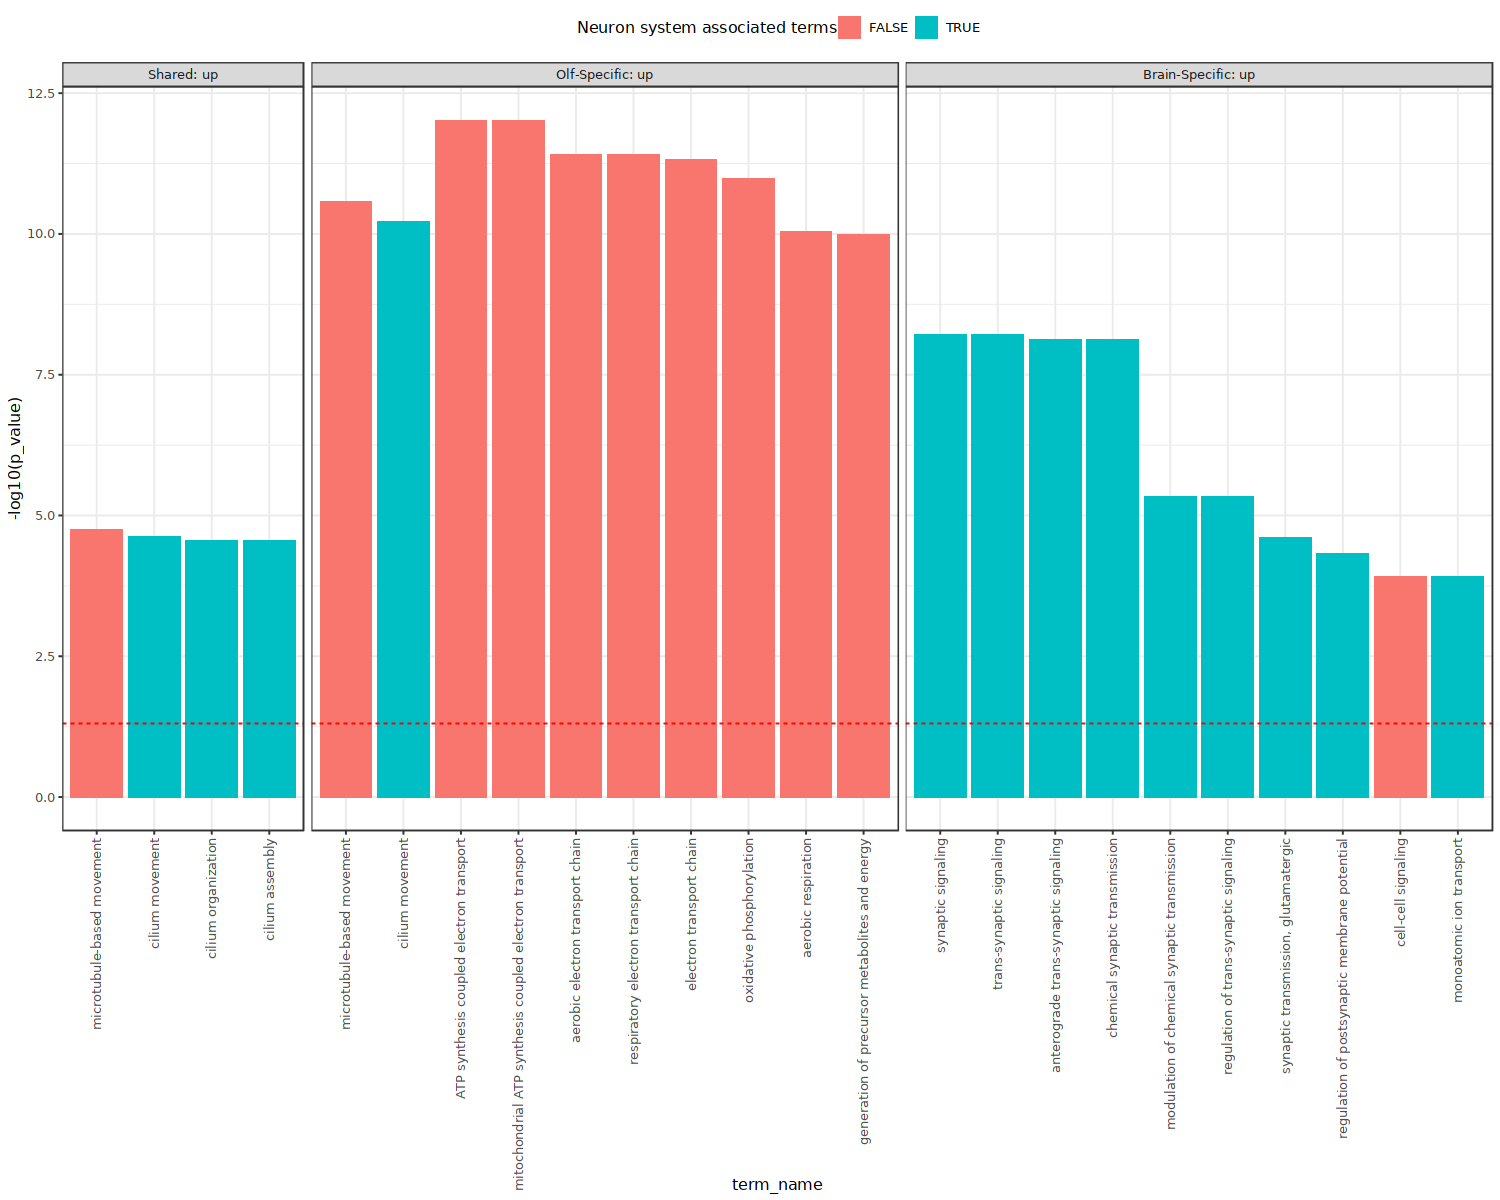

In [470]:
combined_gobp <- rbind(gobps_devDEG_sig%>% mutate(trend = paste0('Shared: ',comb_trend))%>% select(!c(olf_trend, brain_trend,comb_trend)) ,
unique_olf_gobps%>%mutate(trend = paste0('Olf-Specific: ',olf_trend))%>% select(!c(olf_trend)) ,
unique_brain_gobps%>%mutate(trend = paste0('Brain-Specific: ',brain_trend))%>% select(!c(brain_trend)) )%>%group_by(trend)%>%top_n(10, -p_value)
combined_gobp <- subset(combined_gobp, grepl(': up$|: up up',trend))
#combined_gobp$term <- str_split(combined_gobp$Term,pattern = '\\(',simplify = T)[,1]
combined_gobp$term_name <- factor(combined_gobp$term_name, levels = unique(combined_gobp$term_name))
combined_gobp$trend <- gsub('up up','up',combined_gobp$trend)
combined_gobp$trend <- factor(combined_gobp$trend, unique(combined_gobp$trend))

ggplot(combined_gobp, aes(x=term_name,y=-log10(p_value), 
                          fill=grepl('Neur|dendrite|synap|axon |cilium| Ion |Nervous|axonogenesis|Stem cell|projection|myelin',term_name,ignore.case = T)))+
guides(fill=guide_legend(title="Neuron system associated terms"))+
geom_bar(stat = 'identity')+facet_grid(~trend,scales = 'free_x',space = 'free')+theme_bw()+
theme(legend.position = 'top', axis.text.x = element_text(angle = 90,hjust = 1,vjust = 0.5))+
 geom_hline(yintercept=-log10(0.05), linetype="dashed", 
                color = "red", size=0.5)

#dev.print(pdf, file='./figures/enriched_term_overlap_gene_up.pdf',width=10, height=9)
# ggplot(combined_gobp, aes(x=term,y=-log10(p_value), 
#                           fill=grepl('Neur|dendrite|synap|axon |cilium| Ion |Nervous|axonogenesis|Stem cell|projection',term, Term,ignore.case = T)))+
# geom_bar(stat = 'identity')+facet_grid(trend~.,scales = 'free_y',space = 'free')+theme_bw()+
# theme(legend.position = '')+coord_flip()+guides(fill=guide_legend(title="Neuron system associated terms"))



In [471]:
#gobps_devDEG_sig[gobps_devDEG_sig$comb_trend=='down down',]

### rrvgo

[1] "overlap" "up"     




preparing gene to GO mapping data...

preparing IC data...

'select()' returned 1:many mapping between keys and columns



[1] "up"      "overlap"
[1] "olf" "up" 


preparing gene to GO mapping data...

preparing IC data...

Warning message in calculateSimMatrix(go_analysis$term_id, orgdb = "org.Hs.eg.db", :
“Removed 1 terms that were not found in orgdb for BP”
'select()' returned 1:many mapping between keys and columns



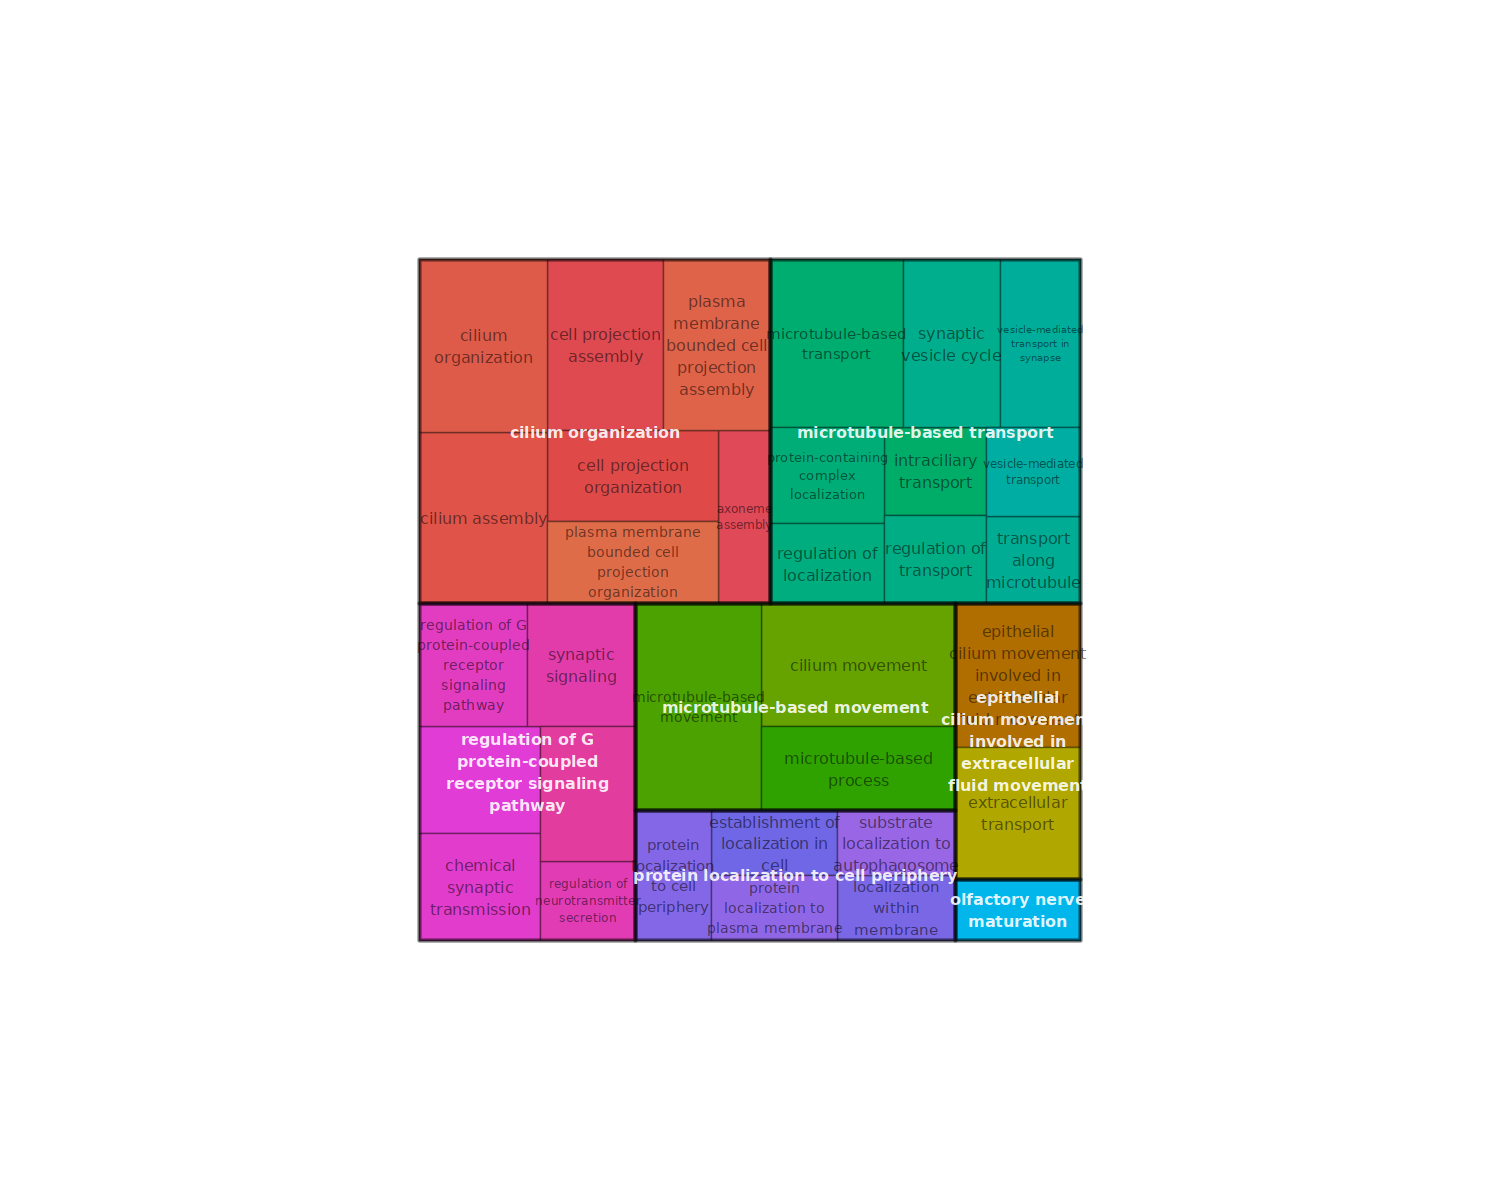

[1] "up"  "olf"
[1] "brain" "up"   


preparing gene to GO mapping data...

preparing IC data...

'select()' returned 1:many mapping between keys and columns



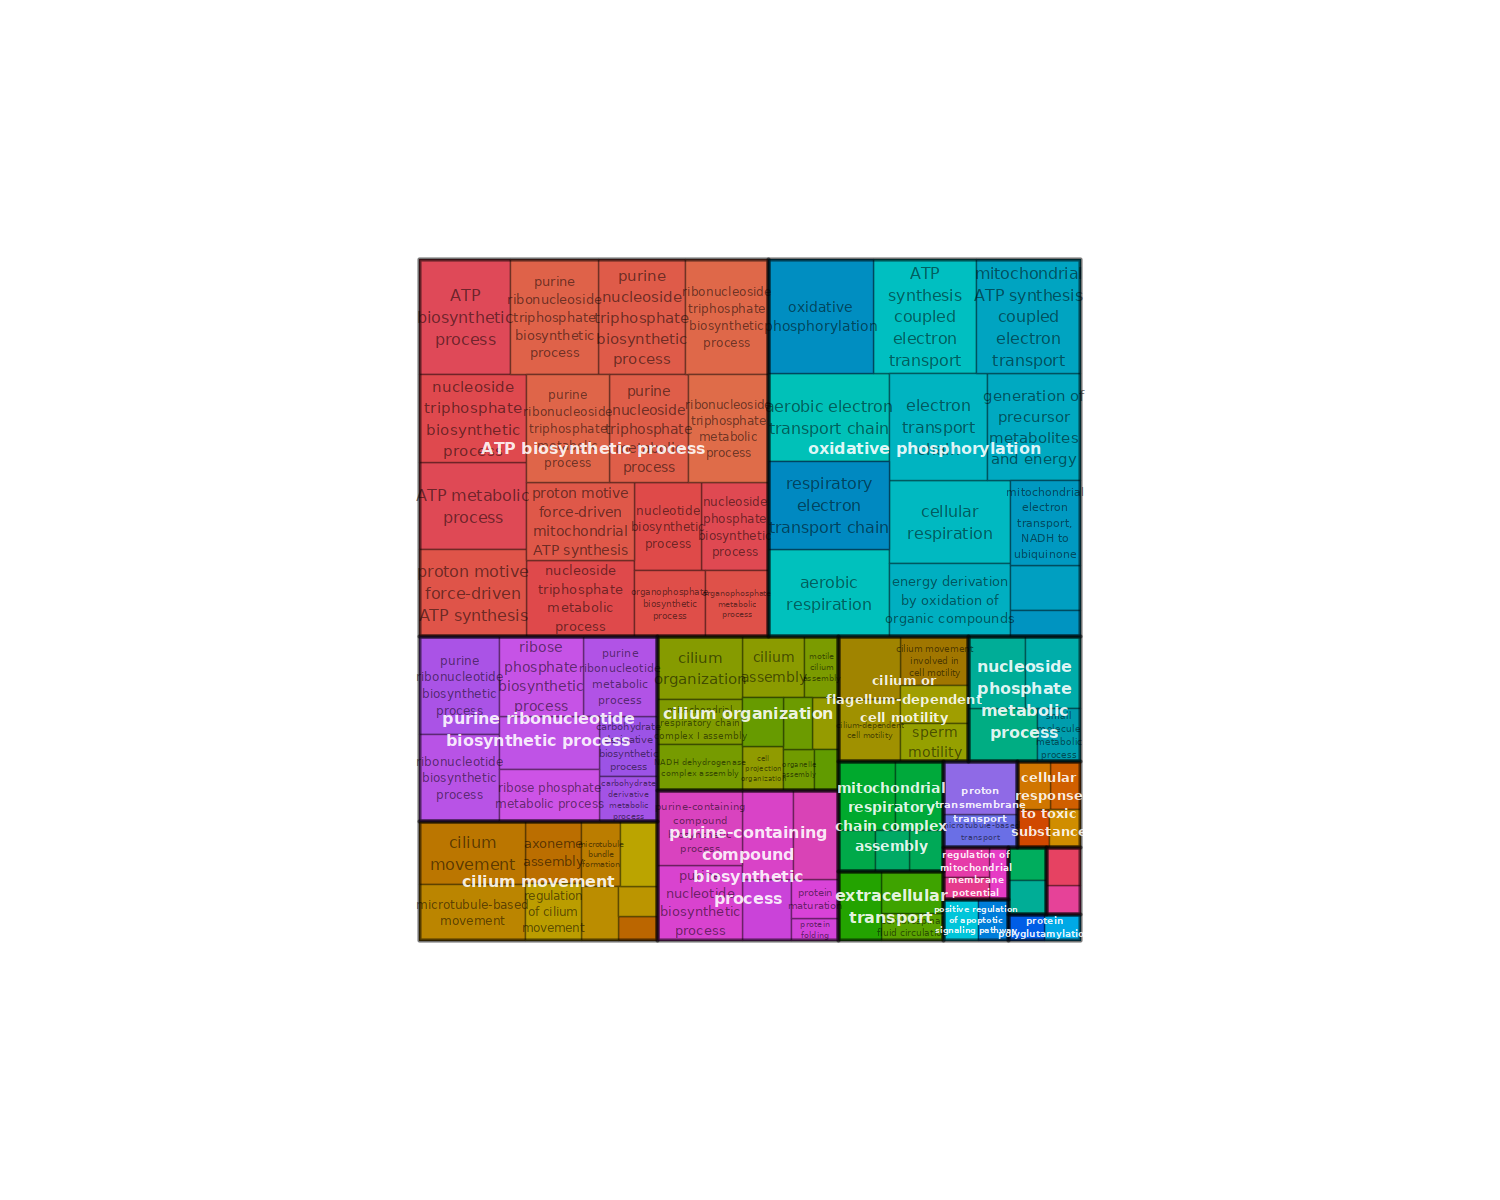

[1] "up"    "brain"
[1] "overlap" "down"   


preparing gene to GO mapping data...

preparing IC data...

'select()' returned 1:many mapping between keys and columns



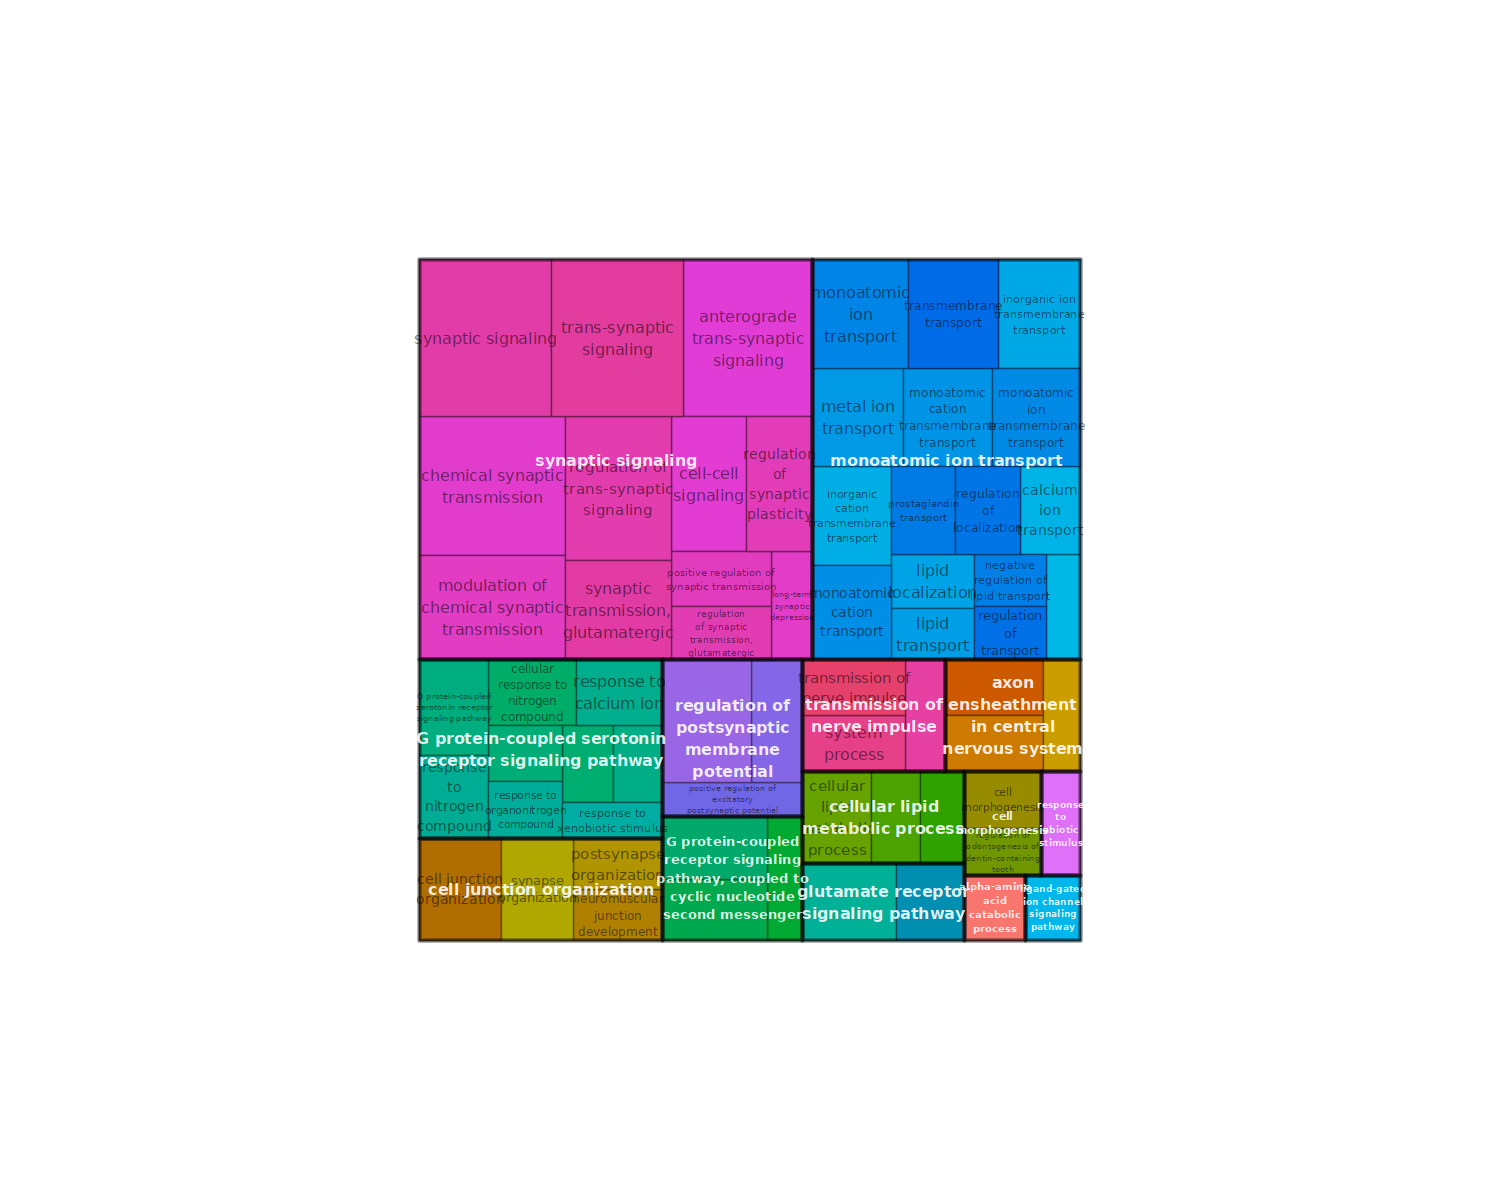

[1] "down"    "overlap"
[1] "olf"  "down"


preparing gene to GO mapping data...

preparing IC data...

'select()' returned 1:many mapping between keys and columns



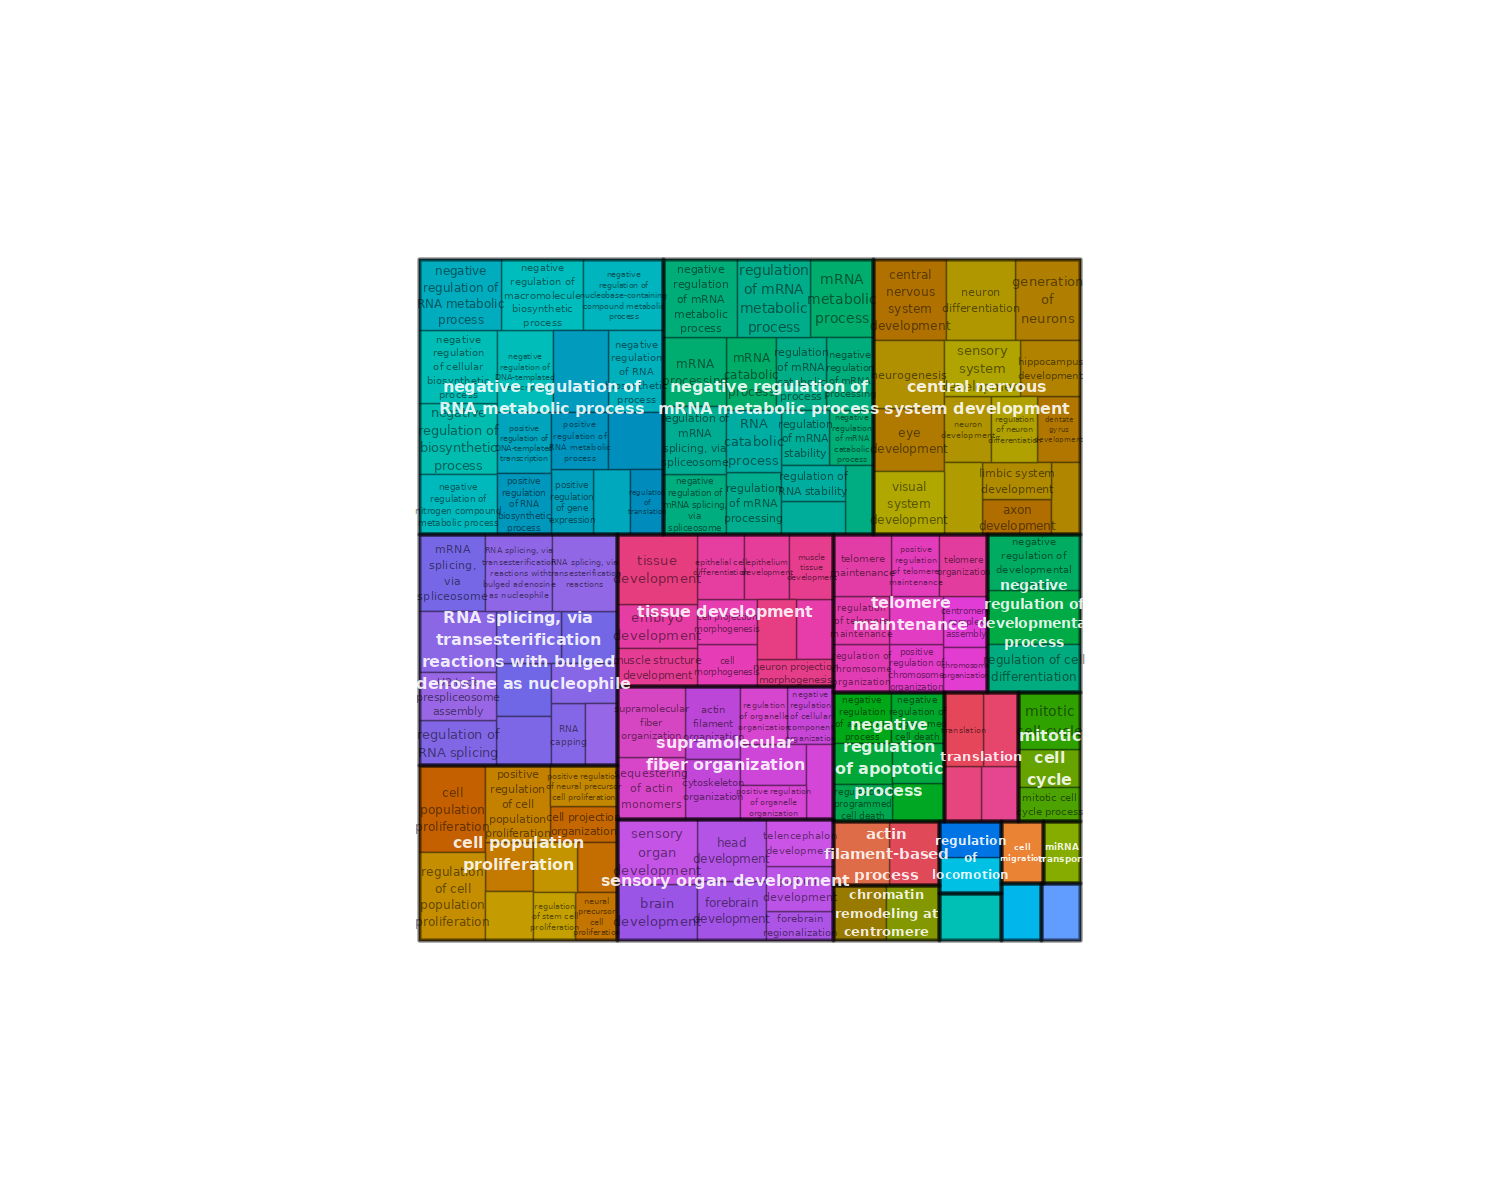

[1] "down" "olf" 
[1] "brain" "down" 


preparing gene to GO mapping data...

preparing IC data...

Warning message in calculateSimMatrix(go_analysis$term_id, orgdb = "org.Hs.eg.db", :
“Removed 1 terms that were not found in orgdb for BP”
'select()' returned 1:many mapping between keys and columns



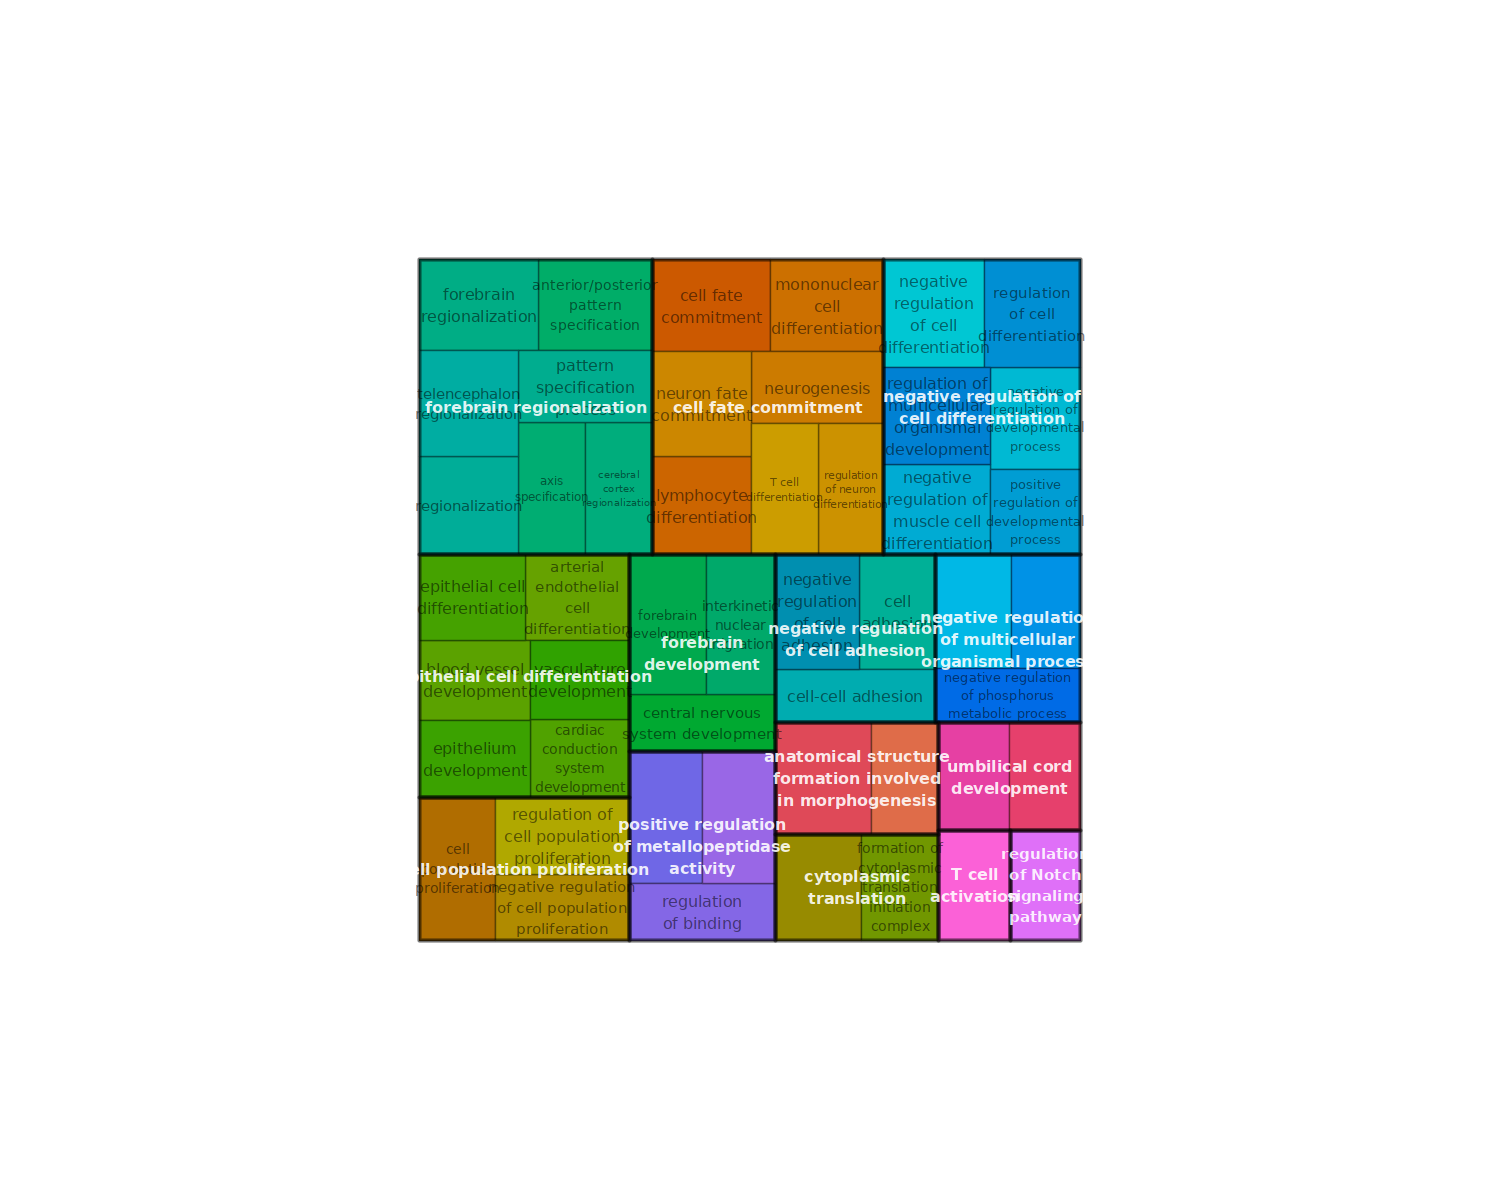

[1] "down"  "brain"


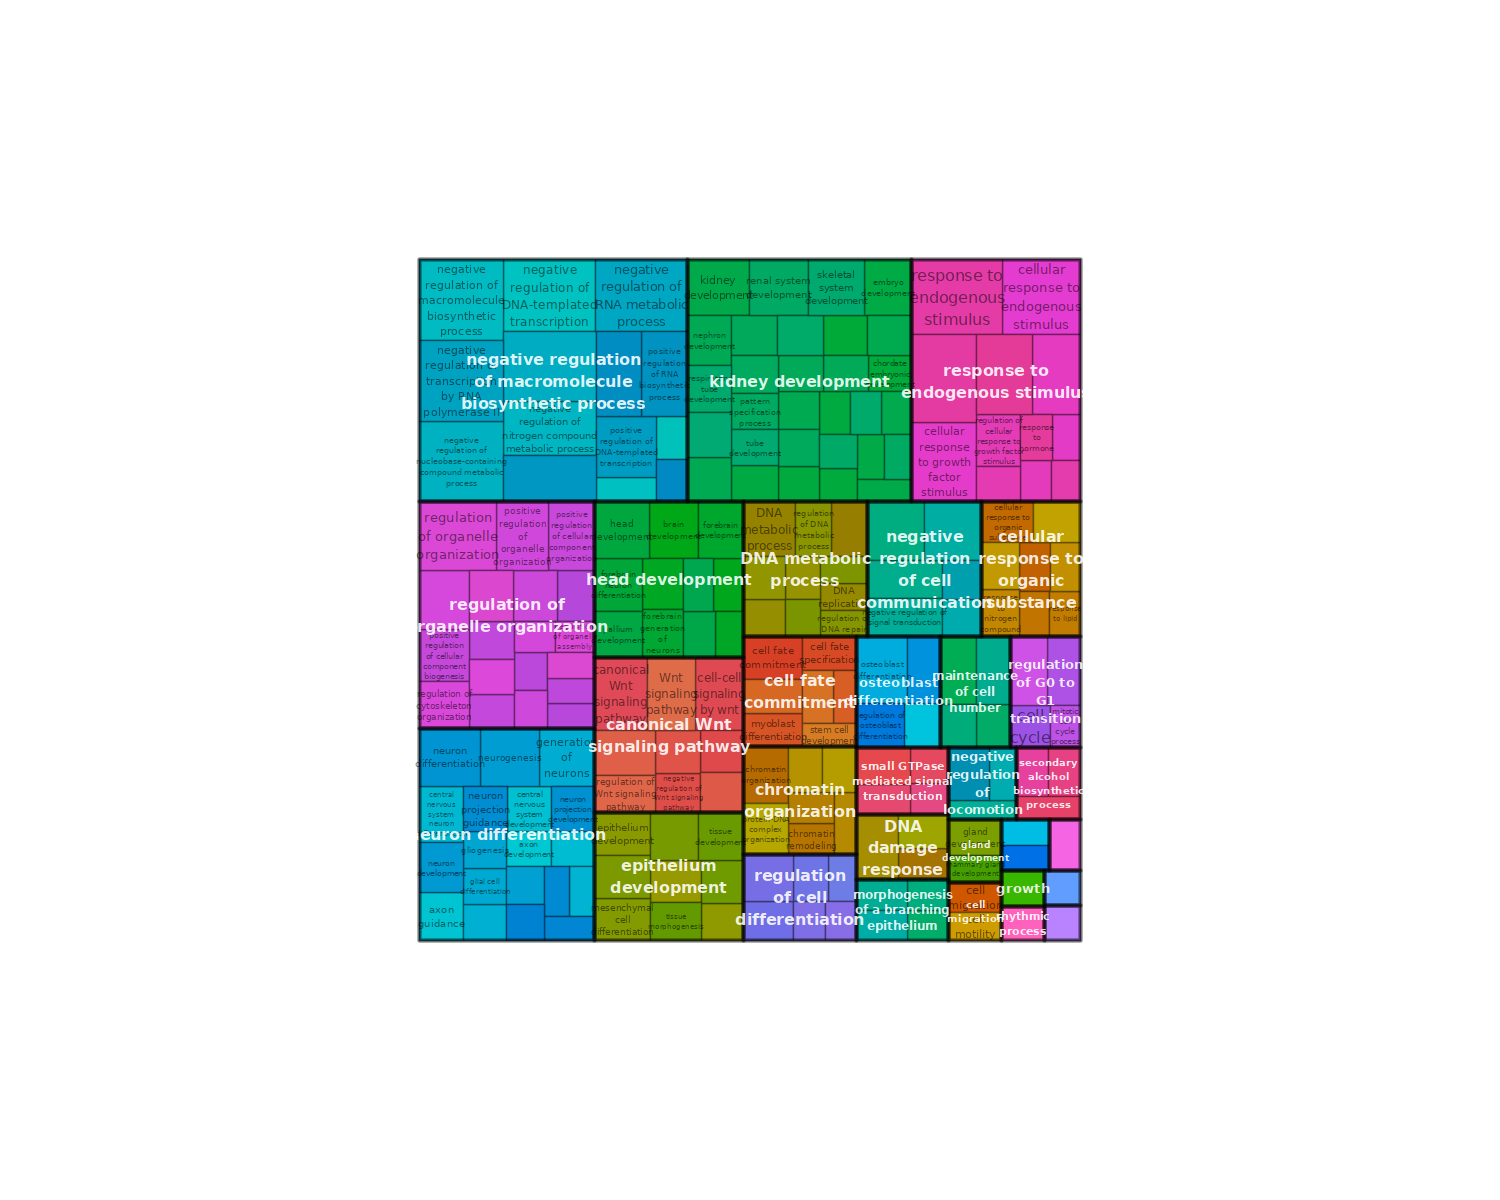

In [6]:
library(rrvgo)

get_bp_enrichr_reducedTerms <- function(trend,overlap,go_analysis){
  #go_analysis$GOID <- str_split(go_analysis$Term,'\\(|\\)',simplify = T)[,2]
  simMatrix <- calculateSimMatrix(go_analysis$term_id,
                                  orgdb="org.Hs.eg.db",
                                  ont="BP",
                                  method="Rel")
  
  
  scores <- setNames(-log10(as.numeric(go_analysis$p_value)), go_analysis$term_id)
  reducedTerms <- reduceSimMatrix(simMatrix,
                                  scores,
                                  orgdb="org.Hs.eg.db")
  
  treemapPlot(reducedTerms)
  print(c(trend,overlap))
    
  reducedTerms_sumscore <-  aggregate(score~parentTerm,reducedTerms, sum)
  reducedTerms_sumscore$overlap <- overlap
  reducedTerms_sumscore$trend <- trend
  reducedTerms_sumscore$term <- reducedTerms_sumscore$parentTerm
  
#   reducedTerms <- reducedTerms%>%group_by(cluster)%>%top_n(1,score)
#   reducedTerms$overlap <- overlap
#   reducedTerms$trend <- trend
#   reducedTerms$term <- reducedTerms$parentTerm
  return(reducedTerms_sumscore)
  
}


go_terms_genelevel <- c()
for(trend in c('up','down')){#,'trans_up','trans_down'
    
  for (overlp in c('overlap','olf','brain')){

    
    if(overlp=='overlap'){GO_analysis=subset(gobps_devDEG, p_value < 0.05 & olf_trend==trend & brain_trend==trend); print(c(overlp,trend  ))}
    if(overlp=='olf'){GO_analysis=subset(unique_olf_gobps, p_value < 0.05 & olf_trend==trend );  print(c(overlp,trend  ))}
    if(overlp=='brain'){GO_analysis=subset(unique_brain_gobps, p_value < 0.05 & brain_trend==trend);  print(c(overlp,trend  ))}
    go_term <- c()
    if(nrow(GO_analysis) >=5 ){
            go_term <- get_bp_enrichr_reducedTerms(trend,overlp,GO_analysis)
    }

    go_terms_genelevel <- rbind(go_terms_genelevel, go_term)
  }
}


In [473]:
#aggregate to table

In [474]:

#go_terms_genelevel
library(dplyr)
library(gridExtra)
go_term_sel <- go_terms_genelevel%>%arrange(desc(score))%>%group_by(overlap,trend)%>%top_n(5,score)
go_term_sel <- aggregate(term~trend+overlap,go_term_sel,'paste')
x <- go_term_sel%>%arrange(trend,desc(overlap ))
x
x$term

trend overlap
1 down  overlap
2 down  olf    
3 down  brain  
4 up    overlap
5 up    olf    
6 up    brain  
  term                                                                                                                                                                                                                                                                                                
1 mRNA metabolic process                                   , negative regulation of RNA metabolic process, central nervous system development                    , RNA splicing, via transesterification reactions with bulged adenosine as nucleophile, sensory organ development                    
2 mononuclear cell differentiation                         , forebrain regionalization                   , regulation of multicellular organismal development    , regulation of Notch signaling pathway                                               , epithelial cell differentiation              
3 negative regulation of transcription by RNA polymerase II, response to endogenous stimulus             , regulation of organelle organization                  , kidney development                                                                  , neurogenesis                                 
4 cilium organization                                      , microtubule-based transport                 , microtubule-based movement                            , regulation of G protein-coupled receptor signaling pathway                          , protein localization to cell periphery       
5 mitochondrial ATP synthesis coupled electron transport   , ATP biosynthetic process                    , microtubule-based movement                            , purine ribonucleotide biosynthetic process                                          , cilium organization                          
6 synaptic signaling                                       , monoatomic ion transport                    , G protein-coupled serotonin receptor signaling pathway, cell junction organization                                                          , regulation of postsynaptic membrane potential

[,1]                                                     
[1,] mRNA metabolic process                                   
[2,] mononuclear cell differentiation                         
[3,] negative regulation of transcription by RNA polymerase II
[4,] cilium organization                                      
[5,] mitochondrial ATP synthesis coupled electron transport   
[6,] synaptic signaling                                       
     [,2]                                        
[1,] negative regulation of RNA metabolic process
[2,] forebrain regionalization                   
[3,] response to endogenous stimulus             
[4,] microtubule-based transport                 
[5,] ATP biosynthetic process                    
[6,] monoatomic ion transport                    
     [,3]                                                  
[1,] central nervous system development                    
[2,] regulation of multicellular organismal development    
[3,] regulation of organelle organization                  
[4,] microtubule-based movement                            
[5,] microtubule-based movement                            
[6,] G protein-coupled serotonin receptor signaling pathway
     [,4]                                                                                
[1,] RNA splicing, via transesterification reactions with bulged adenosine as nucleophile
[2,] regulation of Notch signaling pathway                                               
[3,] kidney development                                                                  
[4,] regulation of G protein-coupled receptor signaling pathway                          
[5,] purine ribonucleotide biosynthetic process                                          
[6,] cell junction organization                                                          
     [,5]                                         
[1,] sensory organ development                    
[2,] epithelial cell differentiation              
[3,] neurogenesis                                 
[4,] protein localization to cell periphery       
[5,] cilium organization                          
[6,] regulation of postsynaptic membrane potential

### PART2: direct pathway overlap-------------------GOBP level----------------------------------------------------------------------------------------------

#### pathway olf

In [23]:
library(enrichR)
library(dplyr)

DEG_Olf_bytrend <- split(DEG_trend_Olf$gene,DEG_trend_Olf$trend_class)
DEG_trend_Olf_gobp <- lapply(DEG_Olf_bytrend, function(x) {df <-    gost(x, source='GO:BP', 
                                                                         custom_bg = custom_olfbg,
                                                                         correction_method = "fdr",
                                                                         #evcodes = TRUE,
                                                                         user_threshold=0.1,significant=F)$result %>%subset(term_size < 2000)  }) 

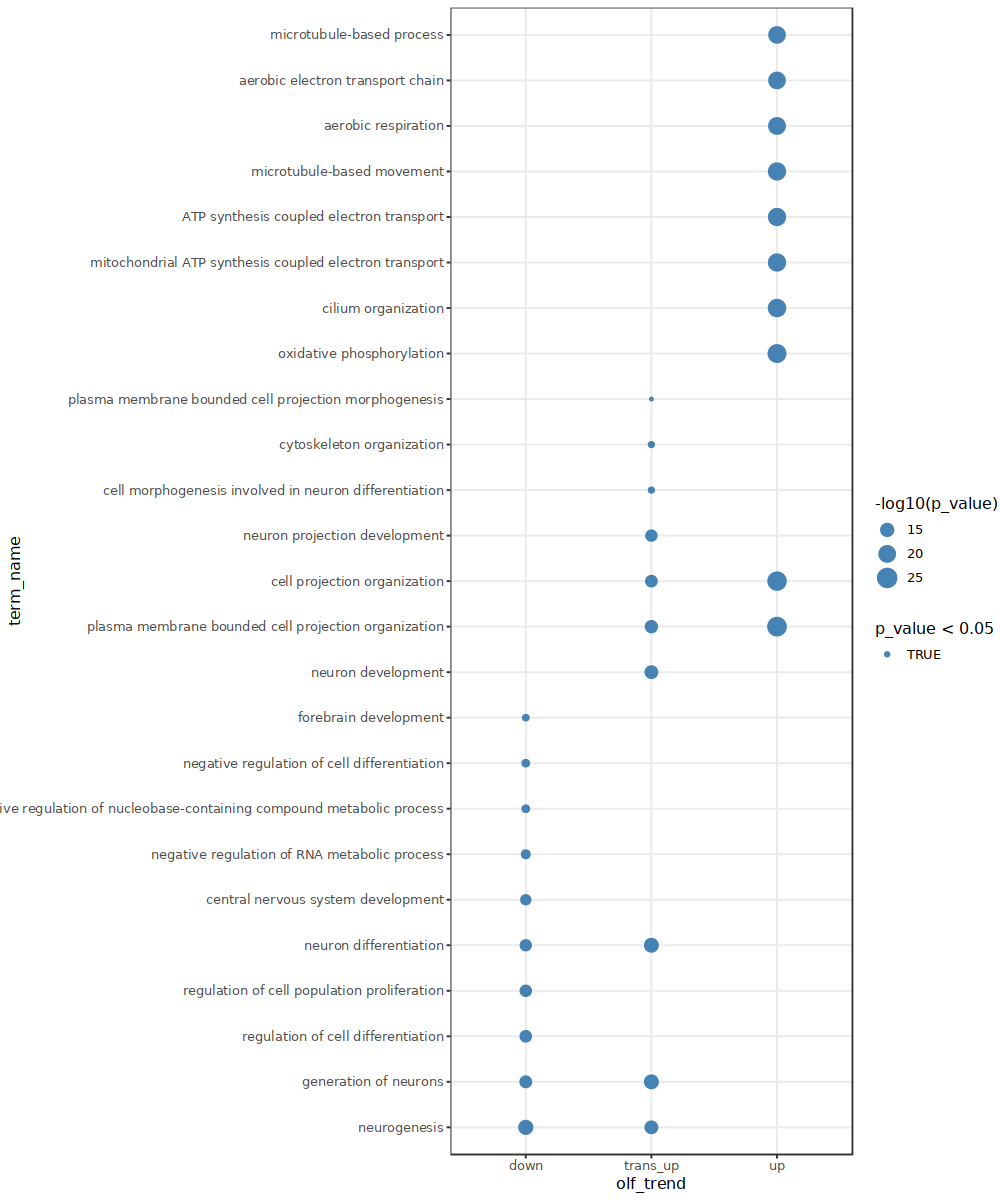

In [24]:
                       
DEG_trend_Olf_gobps <- do.call(rbind,DEG_trend_Olf_gobp)
DEG_trend_Olf_gobps$olf_trend <- str_split(rownames(DEG_trend_Olf_gobps),pattern = '\\.',simplify = T)[,1]
gobps_olf_sig <- subset(DEG_trend_Olf_gobps, p_value < 0.05)

gobps_olf_sig <- gobps_olf_sig%>%group_by(olf_trend)%>%top_n(10, -p_value)
gobps_olf_sig$term_name <- factor(gobps_olf_sig$term_name, levels=unique(gobps_olf_sig$term_name))
#ggplot(gobps_olf_sig, aes(x=olf_trend,y=term_name,size=-log10(p_value)))+geom_point(color='steelblue')+theme_bw()

ggplot(gobps_olf_sig, aes(x=olf_trend,y=term_name,size=-log10(p_value)))+
geom_point(aes(shape=p_value < 0.05),color='steelblue')+theme_bw()

In [25]:
#subset(DEG_trend_Olf_gobps)

#### pathway brain

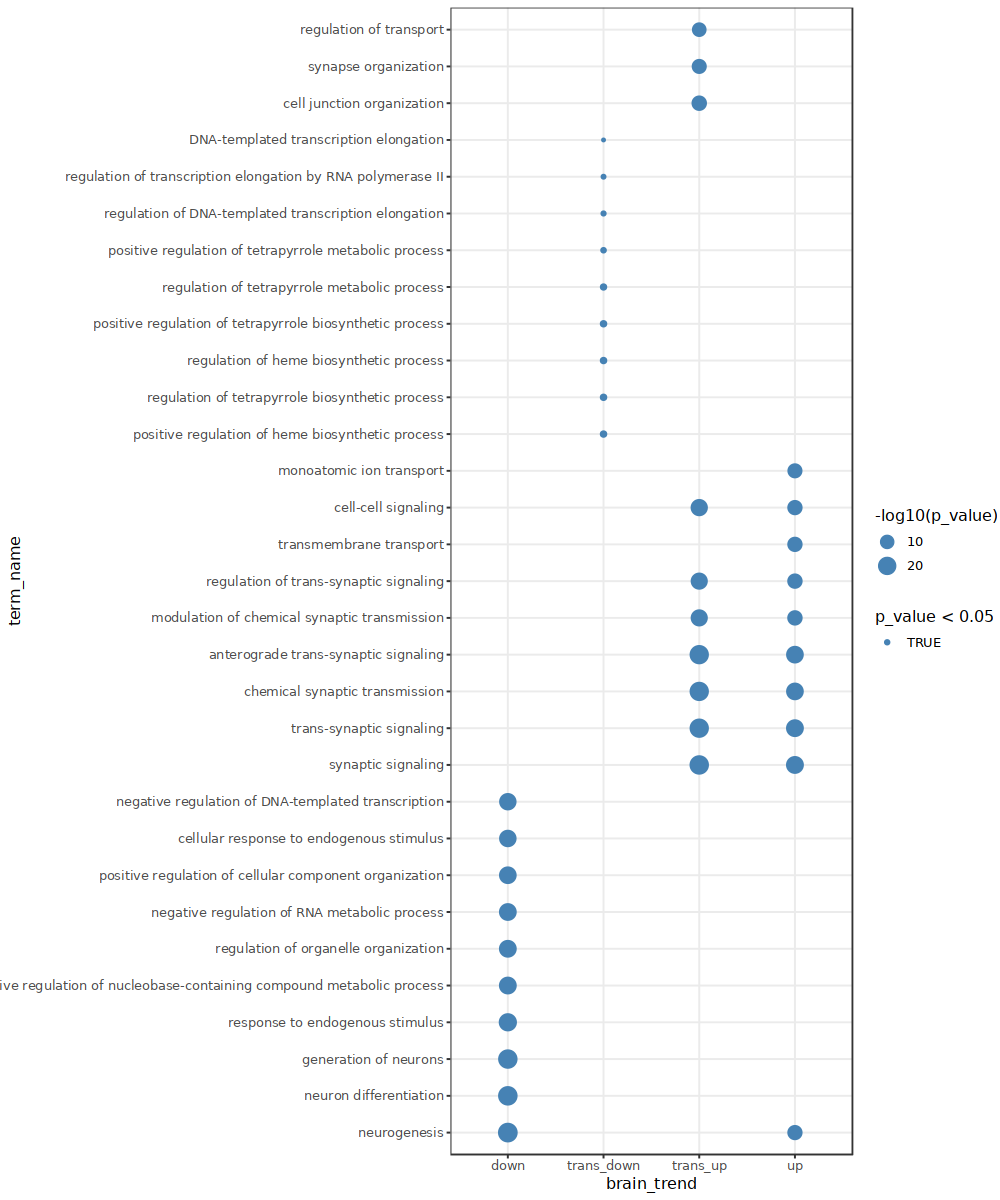

In [26]:
DEG_trend_brain_gobp <- lapply(DEG_trend_Brain, function(x) {df <-    gost(x, source='GO:BP',
                                                                           #custom_bg = brain_bg,
                                                                           #evcodes = TRUE, 
                                                                           correction_method = "fdr",user_threshold=0.1,significant=F)$result %>%subset(term_size < 2000)  } )


DEG_trend_brain_gobps <- do.call(rbind,DEG_trend_brain_gobp)
DEG_trend_brain_gobps$brain_trend <- str_split(rownames(DEG_trend_brain_gobps),pattern = '\\.',simplify = T)[,1]
gobps_brain_sig <- subset(DEG_trend_brain_gobps, p_value < 0.05)

gobps_brain_sig <- gobps_brain_sig%>%group_by(brain_trend)%>%top_n(10, -p_value)

gobps_brain_sig$term_name <- factor(gobps_brain_sig$term_name, levels=unique(gobps_brain_sig$term_name))

ggplot(gobps_brain_sig, aes(x=brain_trend,y=term_name,size=-log10(p_value)))+
geom_point(aes(shape=p_value < 0.05),color='steelblue')+theme_bw()



In [100]:
library(ggrepel)
options(repr.plot.width = 15, repr.plot.height = 10, repr.plot.res = 100)

#DEG_trend_Brain
get_bp_enrichr_reducedTerms <- function(go_analysis){
  #go_analysis$GOID <- str_split(go_analysis$Term,'\\(|\\)',simplify = T)[,2]
  simMatrix <- calculateSimMatrix(go_analysis$term_id,
                                  orgdb="org.Hs.eg.db",
                                  ont="BP",
                                  method="Rel")
  
  
  scores <- setNames(-log10(as.numeric(go_analysis$p_value.x)), go_analysis$term_id)
  reducedTerms <- reduceSimMatrix(simMatrix,
                                  scores,
                                  orgdb="org.Hs.eg.db")

  return(reducedTerms)
  
}


getDEG_gobps_top_rrvgo <- function(trend){
    print(trend)
  DEG_gobps <- merge(DEG_trend_Olf_gobps[DEG_trend_Olf_gobps$olf_trend==trend,c('term_id','term_name','olf_trend','p_value')], 
                     DEG_trend_brain_gobps[DEG_trend_brain_gobps$brain_trend==trend,c('term_id','term_name','brain_trend','p_value')],
                     by=c('term_id','term_name'))#, all.x=T, all.y=T
  
  DEG_gobps_top <- rbind(DEG_gobps%>%top_n(15, -p_value.x), 
                         DEG_gobps%>%top_n(15, -p_value.y)
                         )
  DEG_gobps_top <- DEG_gobps_top[!duplicated(DEG_gobps_top$term_id),]
  
  top_rrvgo <- get_bp_enrichr_reducedTerms(DEG_gobps_top)
  
  
  DEG_gobps_top_rrvgo <- merge(DEG_gobps_top, top_rrvgo[,c('go','parentTerm')], by.x='term_id',by.y='go')
  return(DEG_gobps_top_rrvgo)
}


options(repr.plot.width = 15, repr.plot.height = 10, repr.plot.res = 100)

DEG_gobps_top_rrvgo_down <- getDEG_gobps_top_rrvgo('down')%>%mutate(term=ifelse(term_name==parentTerm, term_name, ''))
DEG_gobps_top_rrvgo_up <- getDEG_gobps_top_rrvgo('up')%>%mutate(term=ifelse(term_name==parentTerm, term_name, ''))
DEG_gobps_top_rrvgo_transup <- getDEG_gobps_top_rrvgo('trans_up')%>%mutate(term=ifelse(term_name==parentTerm, term_name, ''))
#DEG_gobps_top_rrvgo_transdown <- getDEG_gobps_top_rrvgo('trans_down')%>%mutate(term=ifelse(term_name==parentTerm, term_name, ''))


[1] "down"


preparing gene to GO mapping data...

preparing IC data...

'select()' returned 1:many mapping between keys and columns



[1] "up"


preparing gene to GO mapping data...

preparing IC data...

'select()' returned 1:many mapping between keys and columns



[1] "trans_up"


preparing gene to GO mapping data...

preparing IC data...

'select()' returned 1:many mapping between keys and columns



In [55]:
# library(ggrepel)
# options(repr.plot.width = 15, repr.plot.height = 10, repr.plot.res = 100)

# #DEG_trend_Brain
# get_bp_enrichr_reducedTerms <- function(go_analysis){
#   #go_analysis$GOID <- str_split(go_analysis$Term,'\\(|\\)',simplify = T)[,2]
#   simMatrix <- calculateSimMatrix(go_analysis$term_id,
#                                   orgdb="org.Hs.eg.db",
#                                   ont="BP",
#                                   method="Rel")
  
  
#   scores <- setNames(-log10(as.numeric(go_analysis$p_value.x)), go_analysis$term_id)
#   reducedTerms <- reduceSimMatrix(simMatrix,
#                                   scores,
#                                   orgdb="org.Hs.eg.db")

#   return(reducedTerms)
  
# }



# getDEG_gobps_top <- function(trend){
#     print(trend)
#   DEG_gobps <- merge(DEG_trend_Olf_gobps[DEG_trend_Olf_gobps$olf_trend==trend,c('term_id','term_name','olf_trend','p_value')], 
#                      DEG_trend_brain_gobps[DEG_trend_brain_gobps$brain_trend==trend,c('term_id','term_name','brain_trend','p_value')],
#                      by=c('term_id','term_name'))#, all.x=T, all.y=T
  
#   DEG_gobps_top <- rbind(DEG_gobps%>%top_n(15, -p_value.x), 
#                          DEG_gobps%>%top_n(15, -p_value.y)
#                          )
#   DEG_gobps_top <- DEG_gobps_top[!duplicated(DEG_gobps_top$term_id),]
  
#   return(DEG_gobps_top)
# }


# # overall : to have same parent for different trends
# DEG_gobps_top <- rbind(getDEG_gobps_top("down"), getDEG_gobps_top("up"), getDEG_gobps_top('trans_up'))
# DEG_gobps_top <- DEG_gobps_top[!duplicated(DEG_gobps_top$term_id),]
# top_rrvgo_map <- get_bp_enrichr_reducedTerms(DEG_gobps_top)


# getDEG_gobps_top_overall <- function(trend){

#   DEG_gobps_top <- getDEG_gobps_top(trend)
#   top_rrvgo <- get_bp_enrichr_reducedTerms(DEG_gobps_top)
  
#   DEG_gobps_top_rrvgo <- merge(DEG_gobps_top, top_rrvgo[,c('go','parentTerm')], by.x='term_id',by.y='go')
#   DEG_gobps_top_rrvgo$parentTerm_overall <- top_rrvgo_map[DEG_gobps_top_rrvgo$term_id,"parentTerm"]
#   return(DEG_gobps_top_rrvgo)
    
# }


# # options(repr.plot.width = 15, repr.plot.height = 10, repr.plot.res = 100)

# DEG_gobps_top_rrvgo_down <- getDEG_gobps_top_overall('down')%>%mutate(term=ifelse(term_name==parentTerm, term_name, ''))
# DEG_gobps_top_rrvgo_up <- getDEG_gobps_top_overall('up')%>%mutate(term=ifelse(term_name==parentTerm, term_name, ''))
# DEG_gobps_top_rrvgo_transup <- getDEG_gobps_top_overall('trans_up')%>%mutate(term=ifelse(term_name==parentTerm, term_name, ''))
# #DEG_gobps_top_rrvgo_transdown <- getDEG_gobps_top_overall('trans_down')%>%mutate(term=ifelse(term_name==parentTerm, term_name, ''))



[1] "down"
[1] "up"
[1] "trans_up"


preparing gene to GO mapping data...

preparing IC data...

'select()' returned 1:many mapping between keys and columns



[1] "down"


preparing gene to GO mapping data...

preparing IC data...



In [136]:
# c25 <- c(

# "#FB9A99", # lt pink
#   "palegreen2",
#   "#CAB2D6", # lt purple
#   "#FDBF6F",  "green4", # lt orange
#   "gray70", "khaki2",  "#E31A1C", # red
#   "maroon",   "skyblue2", "orchid1", "deeppink1", "blue1", 
#   "darkturquoise",  "#FF7F00", # orange
#     "#6A3D9A", # purple
#     "green1", "yellow4","steelblue4", "yellow3",
#   "darkorange4", "brown", "dodgerblue2"
# )
library(RColorBrewer)
set1_colors <- brewer.pal(n = 8, name = "Set2")[-6]
set3_colors <- brewer.pal(n = 12, name = "Set3")[-12]
c25 <- c(set1_colors, set3_colors)


#parent_t <- unique(rbind(DEG_gobps_top_rrvgo_down,DEG_gobps_top_rrvgo_up, DEG_gobps_top_rrvgo_transup)$parentTerm)
parent_c <- c25[1:length(parent_t)]
names(parent_c) <- parent_t

color_values <- setNames((parent_c), (parent_t))




Warning message:
“Width not defined
ℹ Set with `position_dodge(width = ...)`”
Warning message:
“ggrepel: 8 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


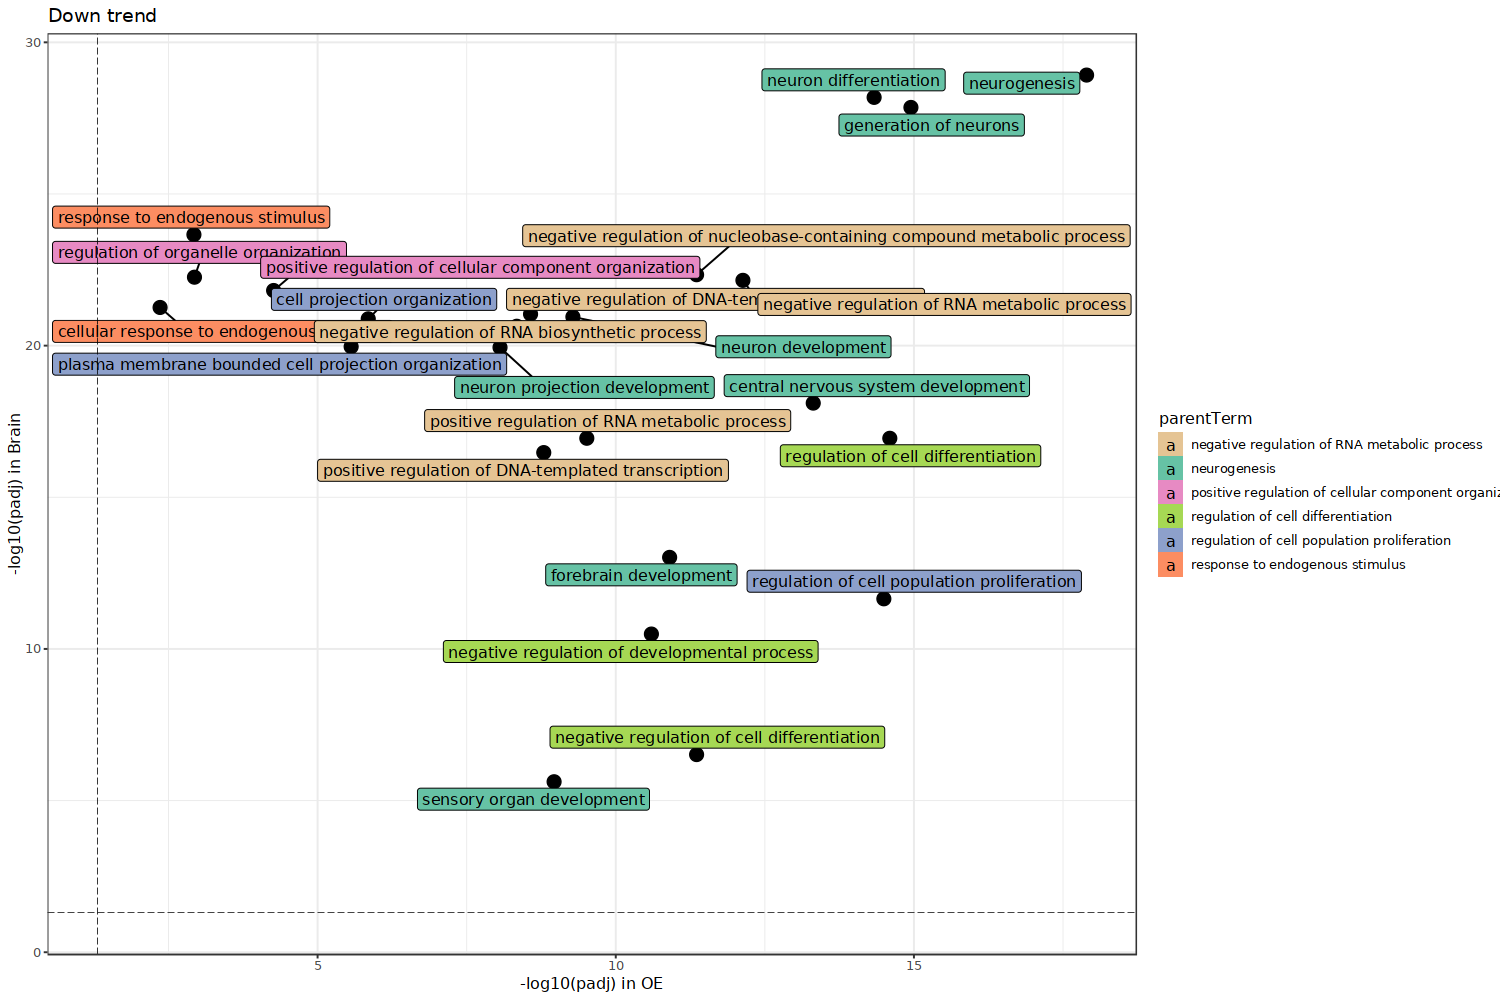

In [137]:
ggplot(DEG_gobps_top_rrvgo_down,aes(x=-log10(p_value.x),y=-log10(p_value.y),fill=parentTerm) )+
geom_point(size=4)+
 geom_label_repel(aes(label=term_name),position = "dodge")+
 # geom_label_repel(aes(label=term),position = "dodge", max.overlaps=30)+
  geom_vline(xintercept = -log10(0.05), linetype = "longdash", lwd=0.2)+
  geom_hline(yintercept = -log10(0.05),linetype = "longdash", lwd=0.2)+
  theme_bw()+xlab('-log10(padj) in OE')+ylab('-log10(padj) in Brain')+ggtitle('Down trend')+
scale_fill_manual(values = color_values)

Warning message:
“Width not defined
ℹ Set with `position_dodge(width = ...)`”
Warning message:
“ggrepel: 8 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“Width not defined
ℹ Set with `position_dodge(width = ...)`”
Warning message:
“ggrepel: 16 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


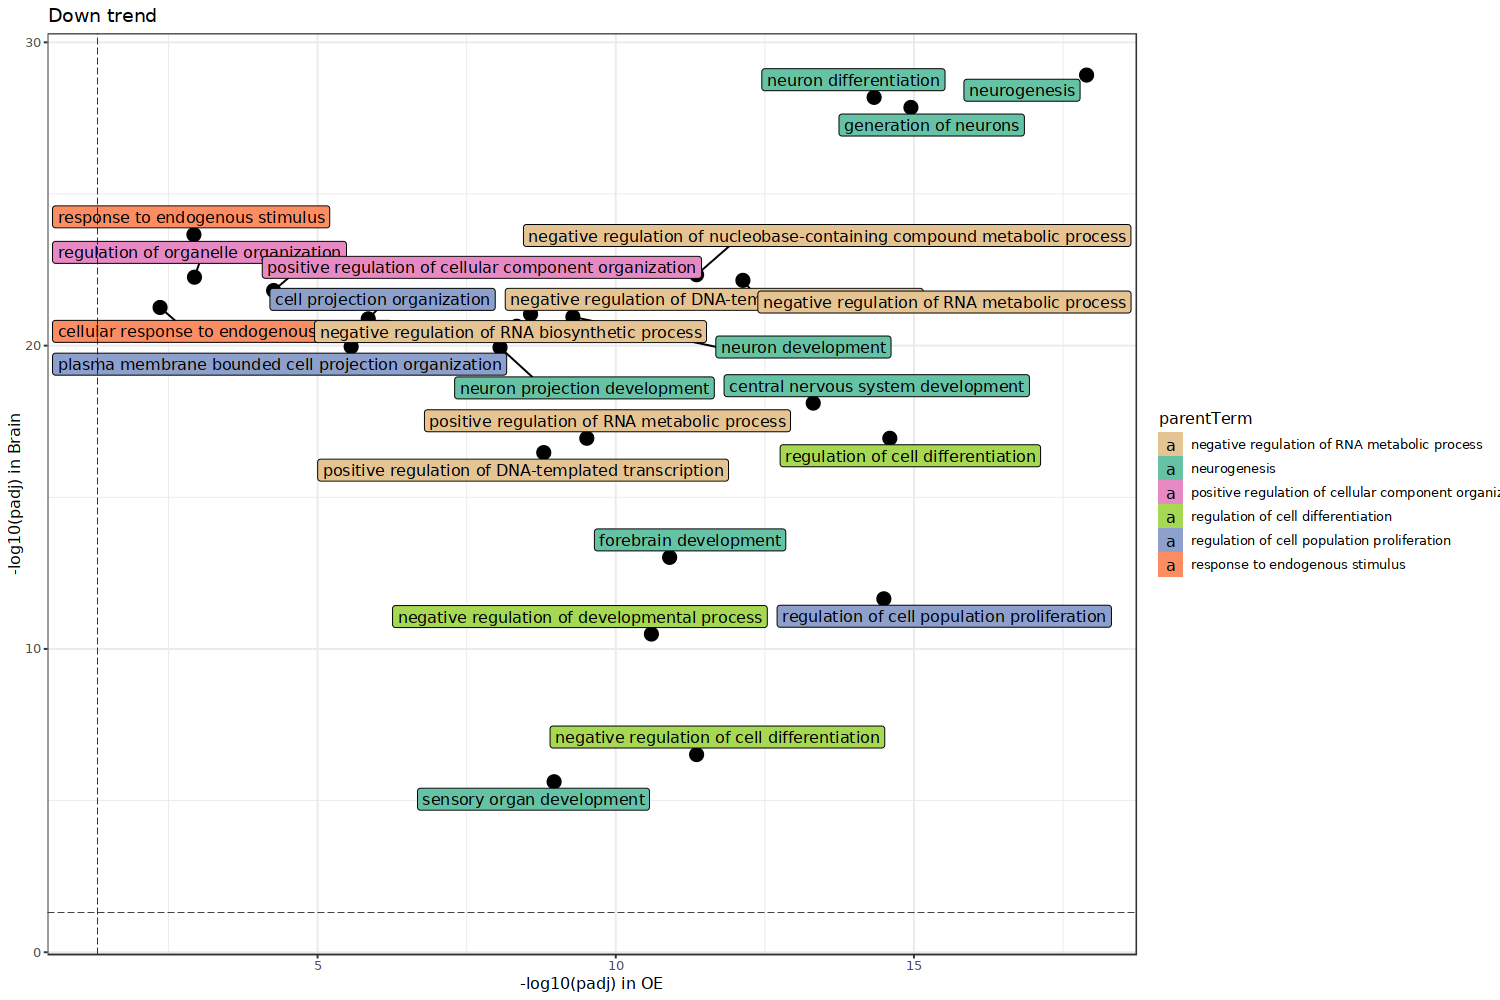

Warning message:
“Width not defined
ℹ Set with `position_dodge(width = ...)`”
Warning message:
“ggrepel: 10 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


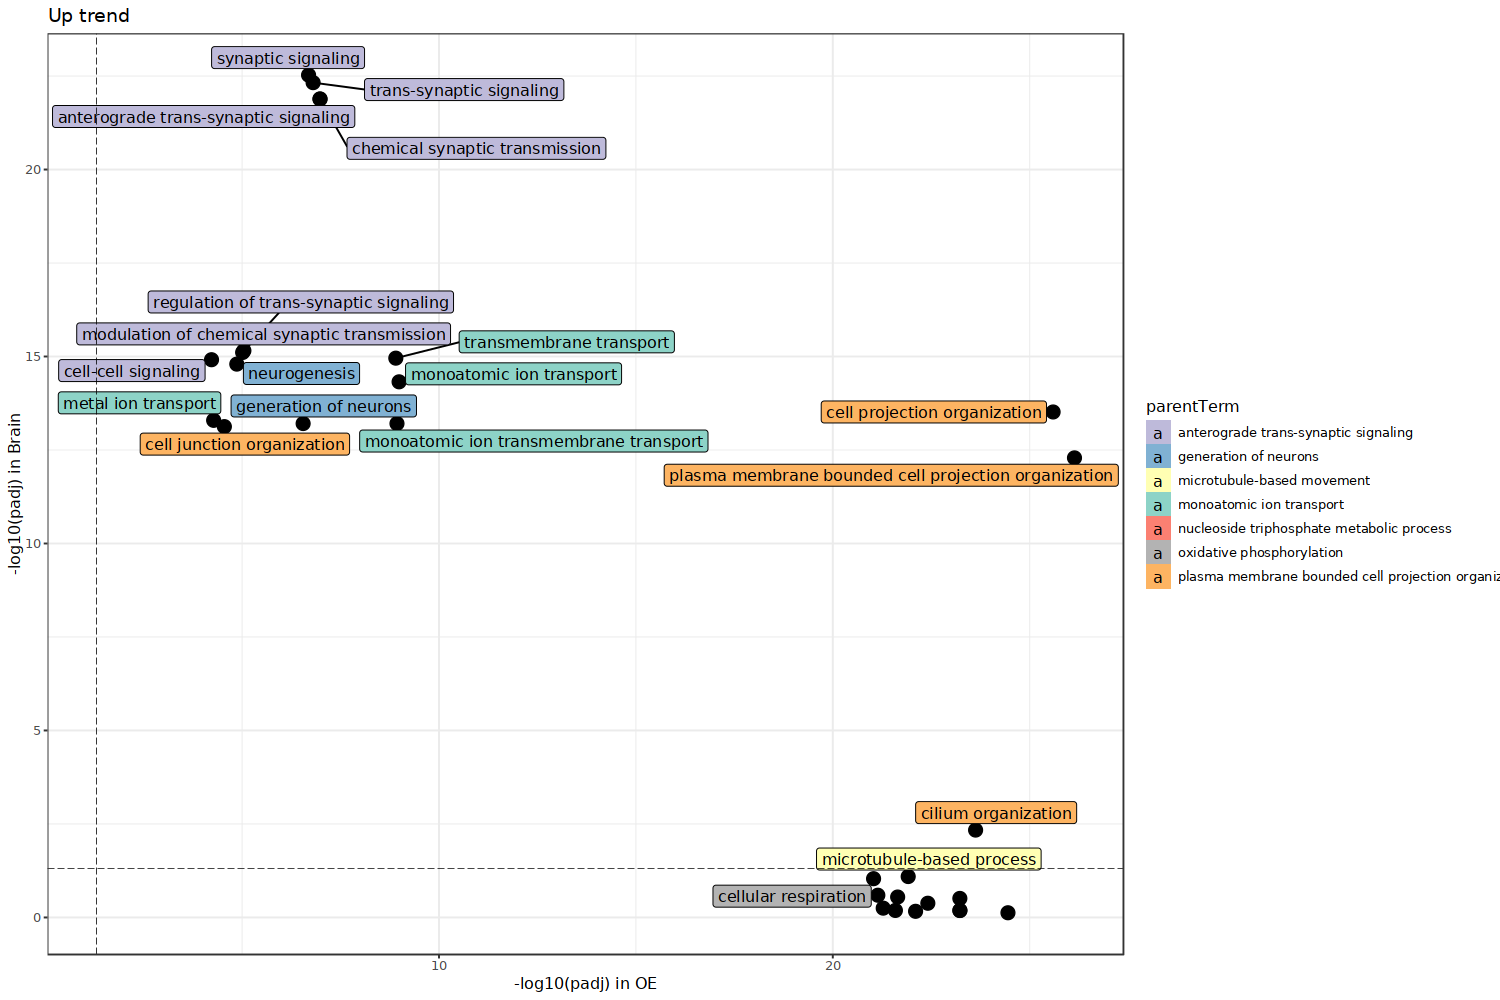

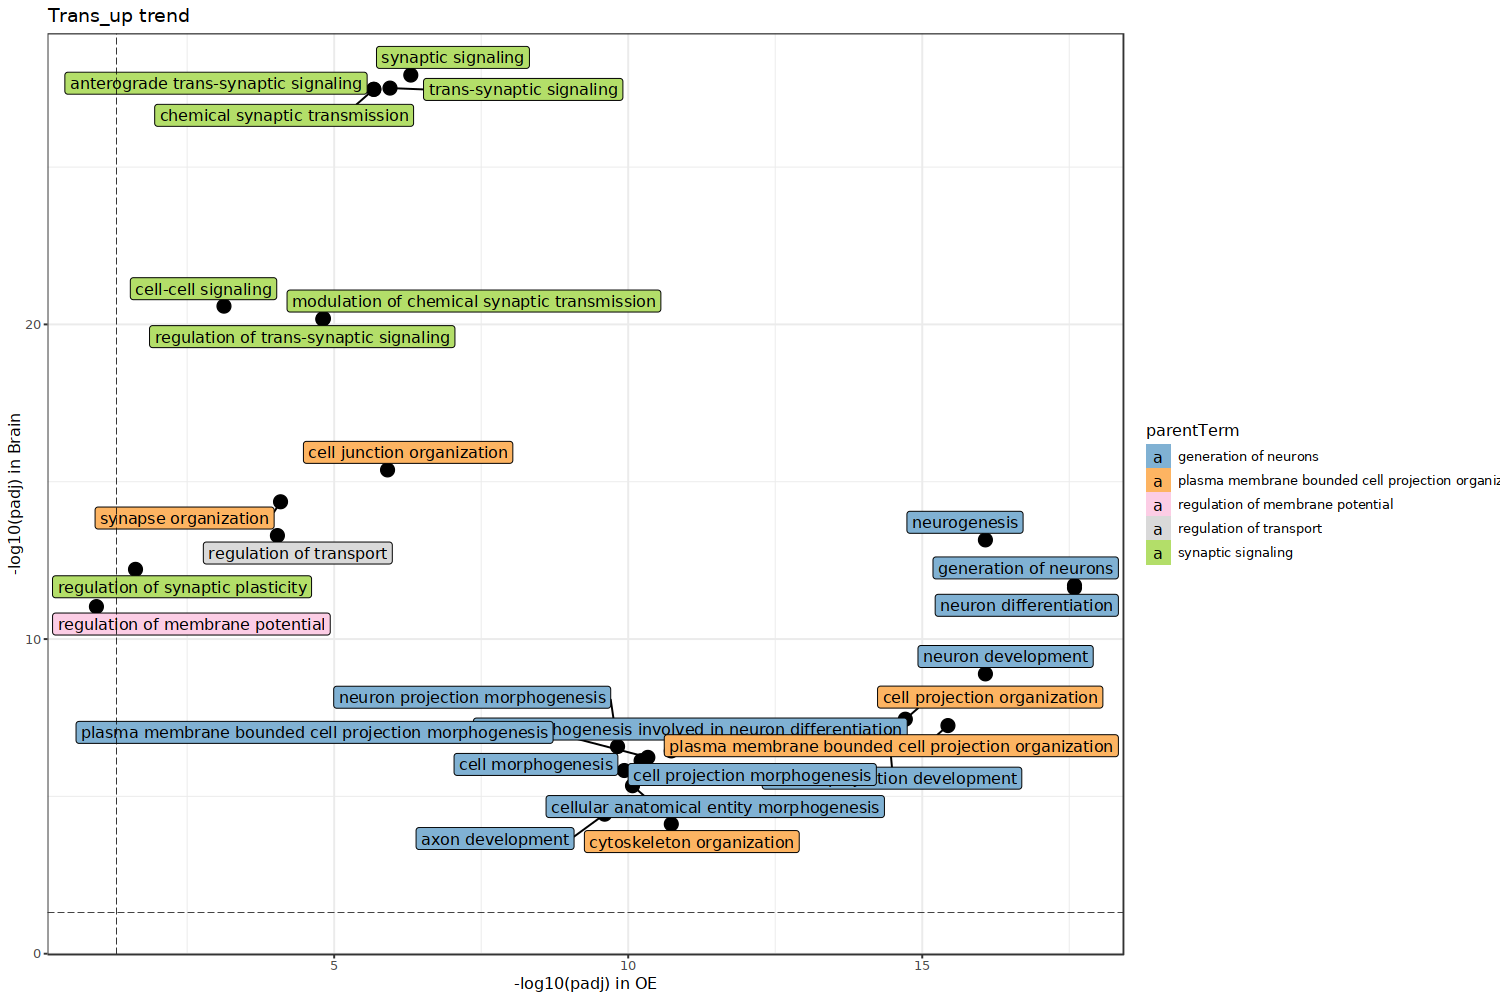

In [138]:

options(repr.plot.width = 15, repr.plot.height = 10, repr.plot.res = 100)
ggplot(DEG_gobps_top_rrvgo_down,aes(x=-log10(p_value.x),y=-log10(p_value.y),fill=parentTerm) )+geom_point(size=4)+
 geom_label_repel(aes(label=term_name),position = "dodge")+
 # geom_label_repel(aes(label=term),position = "dodge", max.overlaps=30)+
  geom_vline(xintercept = -log10(0.05), linetype = "longdash", lwd=0.2)+
  geom_hline(yintercept = -log10(0.05),linetype = "longdash", lwd=0.2)+
  theme_bw()+xlab('-log10(padj) in OE')+ylab('-log10(padj) in Brain')+ggtitle('Down trend')+
scale_fill_manual(values = color_values)

ggplot(DEG_gobps_top_rrvgo_up,aes(x=-log10(p_value.x),y=-log10(p_value.y),fill=parentTerm) )+geom_point(size=4)+
 geom_label_repel(aes(label=term_name),position = "dodge")+ 
  #geom_label_repel(aes(label=term),position = "dodge", max.overlaps=30)+
  geom_vline(xintercept = -log10(0.05), linetype = "longdash", lwd=0.2)+
  geom_hline(yintercept = -log10(0.05),linetype = "longdash", lwd=0.2)+
  theme_bw()+xlab('-log10(padj) in OE')+ylab('-log10(padj) in Brain')+ggtitle('Up trend')+
scale_fill_manual(values = color_values)


ggplot(DEG_gobps_top_rrvgo_transup,aes(x=-log10(p_value.x),y=-log10(p_value.y),fill=parentTerm) )+geom_point(size=4)+
 geom_label_repel(aes(label=term_name),position = "dodge",max.overlaps=20)+ 
 #geom_label_repel(aes(label=term),position = "dodge", max.overlaps=30)+
  geom_vline(xintercept = -log10(0.05), linetype = "longdash", lwd=0.2)+
  geom_hline(yintercept = -log10(0.05),linetype = "longdash", lwd=0.2)+
  theme_bw()+xlab('-log10(padj) in OE')+ylab('-log10(padj) in Brain')+ggtitle('Trans_up trend')+
scale_fill_manual(values = color_values)


# ggplot(DEG_gobps_top_rrvgo_transdown,aes(x=-log10(p_value.x),y=-log10(p_value.y),color=parentTerm) )+geom_point(size=4)+
#  # geom_label_repel(aes(label=term_name),position = "dodge")+ for each term
#   geom_label_repel(aes(label=term),position = "dodge")+
#   geom_vline(xintercept = -log10(0.05), linetype = "longdash", lwd=0.2)+
#   geom_hline(yintercept = -log10(0.05),linetype = "longdash", lwd=0.2)+
#   theme_bw()

In [ ]:
#DEG_gobps_top_rrvgo_down

In [ ]:
ggplot(DEG_gobps_top_rrvgo_down,aes(x=-log10(p_value.x),y=-log10(p_value.y),color=parentTerm) )+geom_point(size=4)+
 geom_text_repel(aes(label=term_name),position = "dodge")+
  #geom_text_repel(aes(label=term),position = "dodge")+
  geom_vline(xintercept = -log10(0.05), linetype = "longdash", lwd=0.2)+
  geom_hline(yintercept = -log10(0.05),linetype = "longdash", lwd=0.2)+
  theme_bw()+xlab('-log10(padj) in OE')+ylab('-log10(padj) in Brain')+ggtitle('Down trend')


### plot traj for selected genes

### get terms & get genes

#### for olf neurons

In [429]:
# 1. neurogenesis
neurogenesis1 <- unlist(str_split(subset(DEG_trend_Olf_gobp$down, term_name=='neurogenesis')$intersection,','))
neurogenesis2 <- unlist(str_split(subset(DEG_trend_Olf_gobp$trans_up, term_name=='neurogenesis')$intersection,','))

# 2. neuron differentiation
neuron_differentiation1 <- unlist(str_split(subset(DEG_trend_Olf_gobp$down, term_name=='neuron differentiation')$intersection,','))
neuron_differentiation2 <- unlist(str_split(subset(DEG_trend_Olf_gobp$trans_up, term_name=='neuron differentiation')$intersection,','))

# 3. neuron projection development
neuron_projection_development1 <- unlist(str_split(subset(DEG_trend_Olf_gobp$down, term_name=='neuron projection development')$intersection,','))
neuron_projection_development2 <- unlist(str_split(subset(DEG_trend_Olf_gobp$trans_up, term_name== 'neuron projection development')$intersection,','))

# 4. axon development
axon_development1 <- unlist(str_split(subset(DEG_trend_Olf_gobp$down, term_name=='axon development')$intersection,','))
axon_development2 <- unlist(str_split(subset(DEG_trend_Olf_gobp$trans_up, term_name=='axon development')$intersection,','))

# 5. metal ion transport
#subset(DEG_trend_Olf_gobp$up, grepl('metal ion transport',term_name))[,1:12]
metal_ion_transport <- unlist(str_split(subset(DEG_trend_Olf_gobp$up, term_name=='metal ion transport')$intersection,','))

# 6. cilium organization
cilium_organization <- unlist(str_split(subset(DEG_trend_Olf_gobp$up, term_name=='cilium organization')$intersection,','))

# 6. cilium organization
neuron_apoptotic_process <-  unlist(str_split(subset(DEG_trend_Olf_gobp$up, term_name=='neuron apoptotic process')$intersection,','))

selected_gene_olf <- list(neurogenesis=c(neurogenesis1,neurogenesis2),
    neuron_differentiation=c(neuron_differentiation1,neuron_differentiation2),
    neuron_projection_development=c(neuron_projection_development1,neuron_projection_development2),
                         axon_development=c(axon_development1, axon_development2),
                         metal_ion_transport=metal_ion_transport,
                         cilium_organization=cilium_organization,
                          neuron_apoptotic_process=neuron_apoptotic_process
)

names(selected_gene_olf) <- str_to_title(names(selected_gene_olf))

In [430]:
subset(DEG_trend_Olf_gobp$down, term_name=='neuron projection development')[,1:12]
subset(DEG_trend_Olf_gobp$trans_up, term_name=='neuron projection development')[,1:12]

query   significant p_value      term_size query_size intersection_size
81 query_1 TRUE        1.890396e-06 921       704        76               
   precision recall   term_id    source term_name                    
81 0.1079545 0.082519 GO:0031175 GO:BP  neuron projection development
   effective_domain_size
81 16452

query   significant p_value      term_size query_size intersection_size
6 query_1 TRUE        2.007297e-09 921       565        75               
  precision recall     term_id    source term_name                    
6 0.1327434 0.08143322 GO:0031175 GO:BP  neuron projection development
  effective_domain_size
6 16452

#### for brain specific 

In [431]:
subset(DEG_trend_brain_gobp$up, grepl('myelination',term_name))[,1:12]

ensheathment_of_neurons <- unlist(str_split(subset(DEG_trend_brain_gobp$up, grepl('ensheathment of neurons',term_name))$intersection,','))

learning_or_memory <- unlist(str_split(subset(DEG_trend_brain_gobp$trans_up, term_name=='learning or memory')$intersection,','))

neuron_apoptotic_process <- unlist(str_split(subset(DEG_trend_brain_gobp$trans_up, term_name=='neuron apoptotic process')$intersection,','))

synapse_organization <- unlist(str_split(subset(DEG_trend_brain_gobp$trans_up, term_name=='synapse organization')$intersection,','))

myelination <- unlist(str_split(subset(DEG_trend_brain_gobp$trans_up, term_name=='myelination')$intersection,','))

selected_gene_brain <- list(ensheathment_of_neurons=ensheathment_of_neurons,
            learning_or_memory=learning_or_memory,
            #neuron_apoptotic_process=neuron_apoptotic_process,
                         synapse_organization=synapse_organization,
                            myelination=myelination
)

names(selected_gene_brain) <- str_to_title(names(selected_gene_brain))

query   significant p_value     term_size query_size intersection_size
99   query_1  TRUE       0.007477774  25       2179       11               
217  query_1  TRUE       0.073685840 147       2179       31               
2926 query_1 FALSE       0.662112650  26       2179        5               
4240 query_1 FALSE       0.754581854  17       2179        3               
5407 query_1 FALSE       0.815694086  44       2179        6               
     precision   recall    term_id    source
99   0.005048187 0.4400000 GO:0022010 GO:BP 
217  0.014226709 0.2108844 GO:0042552 GO:BP 
2926 0.002294631 0.1923077 GO:0022011 GO:BP 
4240 0.001376778 0.1764706 GO:0031643 GO:BP 
5407 0.002753557 0.1363636 GO:0031641 GO:BP 
     term_name                                effective_domain_size
99   central nervous system myelination       17702                
217  myelination                              17702                
2926 myelination in peripheral nervous system 17702                
4240 positive regulation of myelination       17702                
5407 regulation of myelination                17702

In [432]:
get_pc_exp <- function(DEGs){

    load('./data/scdata.RData') 
pseudoTime <- scdata$monocle3_pseudotime
pt.matrix <- as.matrix(scdata@assays$RNA@data[,order(pseudoTime)])
overlap_DEGs <- intersect(DEGs, rownames(pt.matrix))
  pt.matrix <- pt.matrix[overlap_DEGs,]
    
  pt.matrix <- t(apply(pt.matrix,1,function(x){smooth.spline(x,df=3)$y}))


    
xx <- prcomp(pt.matrix, center = F)
xx <- t(as.data.frame((xx$rotation[,'PC1'])))
xxx <- (xx-min(xx))/(max(xx)-min(xx))

    return(xxx)
}

# mean_selected_gene_brain <- do.call(rbind,lapply(selected_gene_brain,get_pc_exp ))
# mean_selected_gene_Olf <- do.call(rbind,lapply(selected_gene_olf,get_pc_exp ))
# rownames(mean_selected_gene_brain) <- names(selected_gene_brain)
# rownames(mean_selected_gene_Olf) <- names(selected_gene_olf)


In [451]:
get_mean_exp <- function(DEGs){

    load('./data/scdata.RData') 
pseudoTime <- scdata$monocle3_pseudotime
pt.matrix <- as.matrix(scdata@assays$RNA@data[,order(pseudoTime)])

    
    overlap_DEGs <- intersect(DEGs, rownames(pt.matrix))
  
  pt.matrix <- pt.matrix[overlap_DEGs,]
  
  pt.matrix <- t(apply(pt.matrix,1,function(x){smooth.spline(x,df=3)$y}))
  #pt.matrix <- t(apply(pt.matrix,1,function(x){(x-mean(x))/sd(x)}))
  #pt.matrix <- t(apply(pt.matrix,1,function(x){(x-min(x))/(max(x)-min(x))}))

  
  rownames(pt.matrix) <- overlap_DEGs
  colnames(pt.matrix) <- colnames(scdata)[order(pseudoTime)]

  #print(pt.matrix)
  #pt.matrix_melt <- melt(pt.matrix)
  #pt.matrix_melt$pseudoTime <- scdata@meta.data[pt.matrix_melt$Var2,'monocle3_pseudotime']
  
  #xx <- subset(pt.matrix_melt,Var1=='DRAXIN')
  
  # ggplot(pt.matrix_melt, aes(x=pseudoTime, y=value, group=Var1)) +
  #     geom_smooth(method = "loess",se = F)+
  #     xlab('Pseudotime')+ylab('Expression')+theme_bw()
  pt.matrix <- pt.matrix[!rowSums(is.na(pt.matrix))>0,]

  meanexp <-  t(as.data.frame(colMeans(pt.matrix)))
    return(meanexp)
}

# get mean expression 
mean_selected_gene_brain <- do.call(rbind,lapply(selected_gene_brain,get_mean_exp ))
mean_selected_gene_Olf <- do.call(rbind,lapply(selected_gene_olf,get_mean_exp ))
rownames(mean_selected_gene_brain) <- names(selected_gene_brain)
rownames(mean_selected_gene_Olf) <- names(selected_gene_olf)


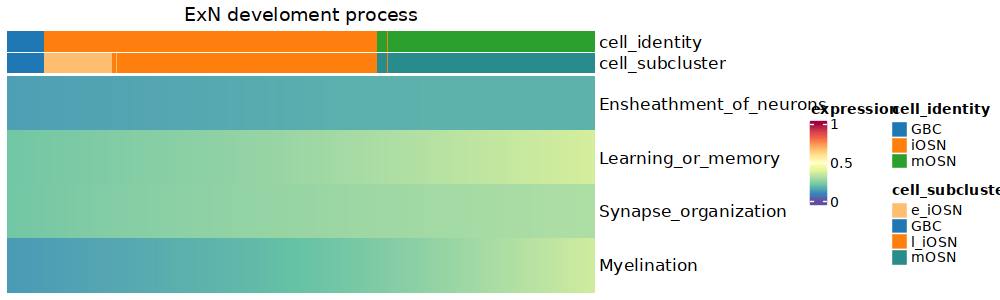

In [455]:
options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 100)

  plot(Heatmap(
   mean_selected_gene_brain,
      name = "expression",
      column_title = 'ExN develoment process',
      cluster_columns              = F,
      cluster_rows              = F,
        col    = colorRamp2(seq(from=0,to=1,length=11),rev(brewer.pal(11, "Spectral"))),

    show_row_names               = T,
    show_column_names            = FALSE,
    show_row_dend = F,
      top_annotation = HeatmapAnnotation(
      cell_identity=scdata@meta.data[colnames(pt.matrix),'cca_N_types'],
          cell_subcluster = scdata@meta.data[colnames(pt.matrix),'N_types_stage'],
      #batch=scdata@meta.data[colnames(pt.matrix),'batch'],
      #subc=scdata@meta.data[colnames(pt.matrix),'N_leiden_res0_2'],
#       pseudotime=sort(pseudoTime),
      col = list(cell_identity =N_color,
                 cell_subcluster=Nstage_color ,
                 pseudotime= colorRamp2(c(0, 15 ,30), c("white","#8700A8","#35008C"))
      )
    )))


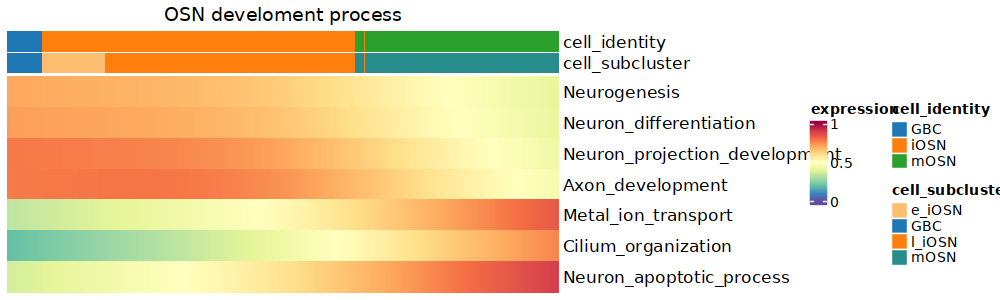

In [457]:

    
options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 100)

  plot(Heatmap(
   mean_selected_gene_Olf,
      name = "expression",
      column_title = 'OSN develoment process',
      cluster_columns              = F,
      cluster_rows              = F,
        col    = colorRamp2(seq(from=0,to=1,length=11),rev(brewer.pal(11, "Spectral"))),

    show_row_names               = T,
    show_column_names            = FALSE,
    show_row_dend = F,
      top_annotation = HeatmapAnnotation(
      cell_identity=scdata@meta.data[colnames(pt.matrix),'cca_N_types'],
          cell_subcluster = scdata@meta.data[colnames(pt.matrix),'N_types_stage'],
      #batch=scdata@meta.data[colnames(pt.matrix),'batch'],
      #subc=scdata@meta.data[colnames(pt.matrix),'N_leiden_res0_2'],
#       pseudotime=sort(pseudoTime),
      col = list(cell_identity =N_color,
                 cell_subcluster=Nstage_color ,
                 pseudotime= colorRamp2(c(0, 15 ,30), c("white","#8700A8","#35008C"))
      )
    )))

  

### plot_heatmap_trend

In [460]:
options(repr.plot.width = 10, repr.plot.height = 2, repr.plot.res = 100)

library(stringr)
library(ggplot2)
library(reshape2)
library(ComplexHeatmap)
library(ggpubr)

load('./data/scdata.RData') 
pseudoTime <- scdata$monocle3_pseudotime
pt.matrix <- as.matrix(scdata@assays$RNA@counts[,order(pseudoTime)])


scdata$N_types_stage <- scdata$cca_N_types_stage

Nstage_color <- c('#1f77b4','#FDBF6F','#ff7f0e',"#298c8c")
names(Nstage_color) <- c('GBC','e_iOSN','l_iOSN','mOSN')


plot_heatmap_trend <- function(DEGs,trend){
  
  overlap_DEGs <- intersect(DEGs, rownames(pt.matrix))
  
  pt.matrix <- pt.matrix[overlap_DEGs,]
  
  pt.matrix <- t(apply(pt.matrix,1,function(x){smooth.spline(x,df=3)$y}))
  #pt.matrix <- t(apply(pt.matrix,1,function(x){(x-mean(x))/sd(x)}))
  #pt.matrix <- t(apply(pt.matrix,1,function(x){(x-min(x))/(max(x)-min(x))}))

  
  rownames(pt.matrix) <- overlap_DEGs
  colnames(pt.matrix) <- colnames(scdata)[order(pseudoTime)]

  pt.matrix <- pt.matrix[!rowSums(is.na(pt.matrix))>0,]

  plot(Heatmap(
    pt.matrix,name = "expression",
      column_title = trend,
      cluster_columns              = F,
      cluster_rows              = T,
        col    = colorRamp2(seq(from=0,to=5,length=11),rev(brewer.pal(11, "Spectral"))),

    show_row_names               = FALSE,
    show_column_names            = FALSE,
    show_row_dend = F,
#       top_annotation = HeatmapAnnotation(
#       cell_identity=scdata@meta.data[colnames(pt.matrix),'N_types'],
#           cell_subcluster = scdata@meta.data[colnames(pt.matrix),'N_types_stage'],
#       #batch=scdata@meta.data[colnames(pt.matrix),'batch'],
#       #subc=scdata@meta.data[colnames(pt.matrix),'N_leiden_res0_2'],
#       pseudotime=sort(pseudoTime),
#       col = list(cell_identity =N_color,cell_subcluster=Nstage_color ,
#                  pseudotime= colorRamp2(c(0, 15 ,30), c("white","#8700A8","#35008C"))
#       )
#     )
  ))
    
    
  
  g_mean <- as.data.frame(cbind(colMeans(pt.matrix,na.rm = T),sort(pseudoTime)))
  g_mean$cell_type=scdata@meta.data[rownames(g_mean),'N_types_stage']
  
plot1 <-  ggplot(g_mean, aes(V2, V1)) +
          geom_smooth(method = "loess",formula = y~x)+
          xlab('Pseudotime')+ylab('Expression')+theme_bw()#+
          #ggtitle(trend)

plot2 <- ggplot(g_mean) +
          xlab('celltype')+ylab('')+theme_void()+
          theme(legend.position='top')+
          geom_jitter( aes(x=V2,y=1,color=cell_type),size=2,height = 0.01)+
    scale_color_manual(values =  c('#1f77b4','#FDBF6F','#ff7f0e','#2ca02c'),breaks = c('GBC','e_iOSN','l_iOSN','mOSN'))



#plot(ggarrange(plot2, plot1, nrow = 2, heights = c(1, 7), align = 'hv'))
    plot(plot1)
 }

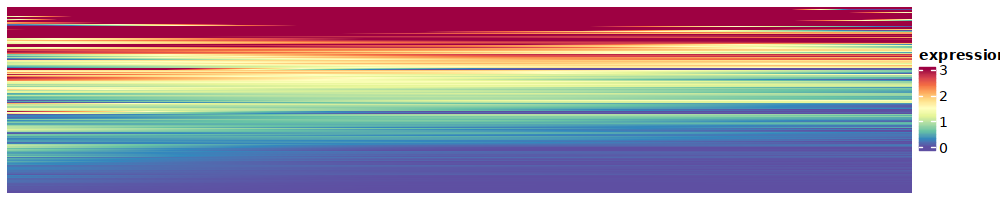

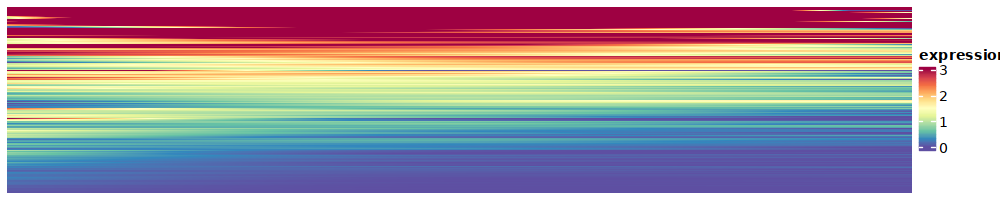

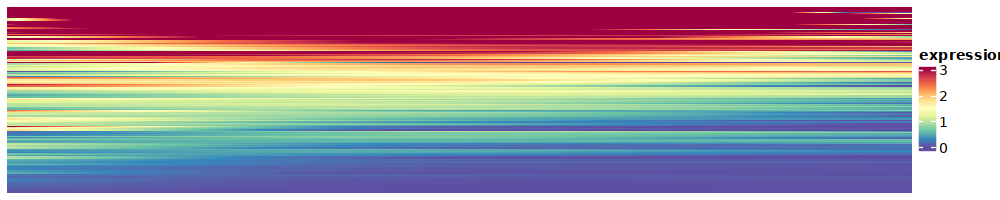

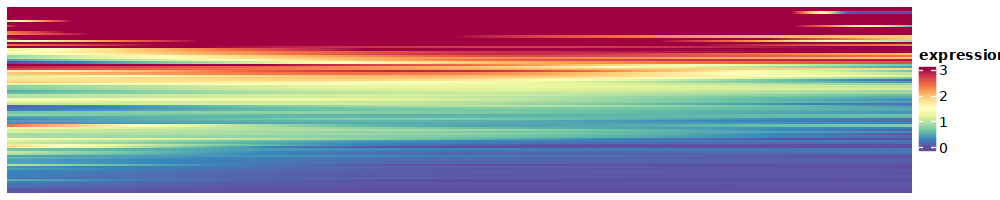

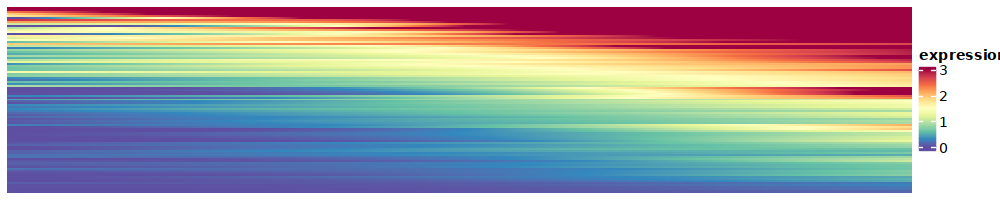

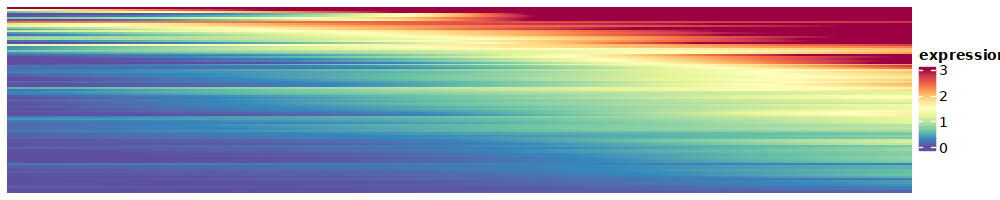

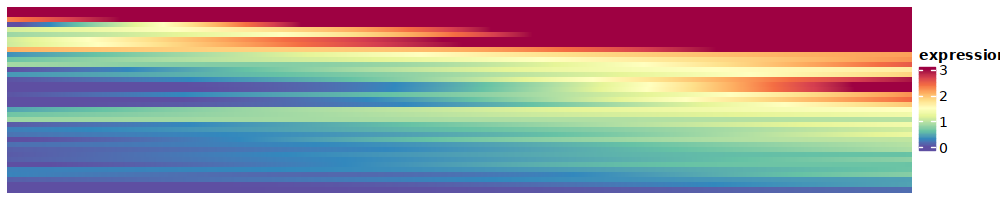

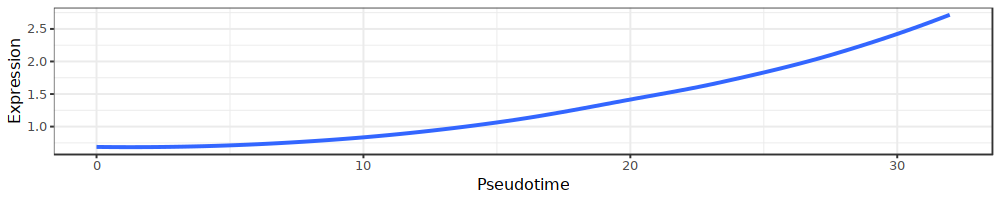

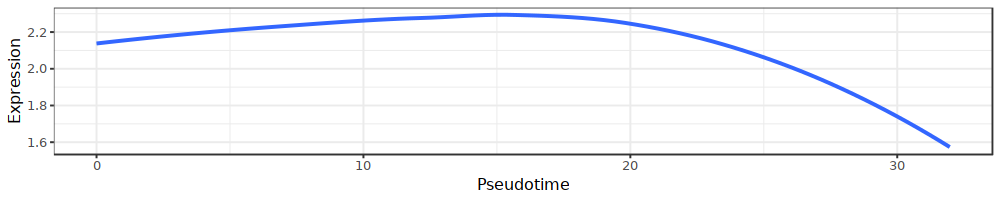

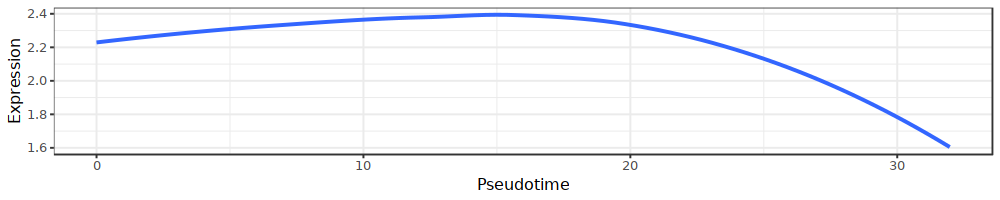

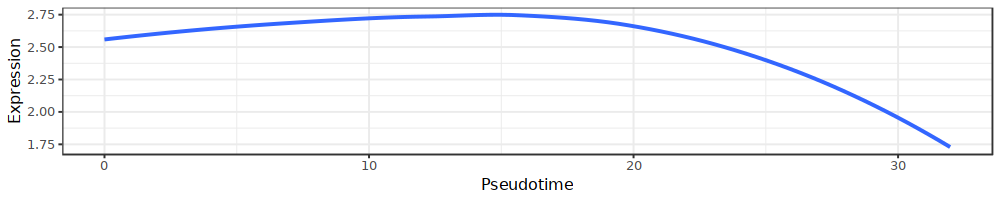

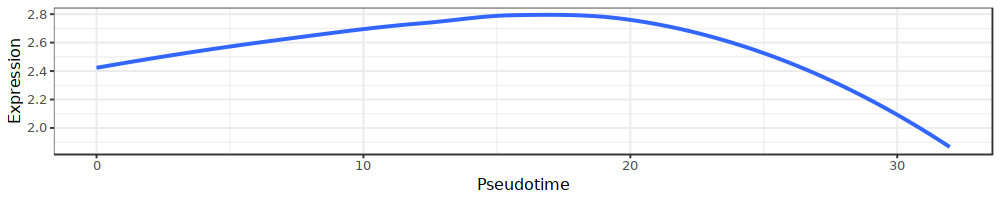

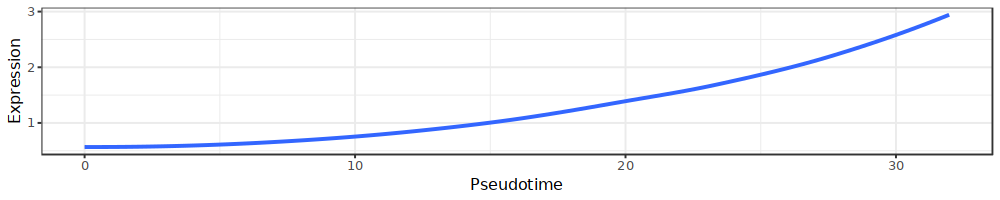

$Neurogenesis

$Neuron_differentiation

$Neuron_projection_development

$Axon_development

$Metal_ion_transport

$Cilium_organization

$Neuron_apoptotic_process


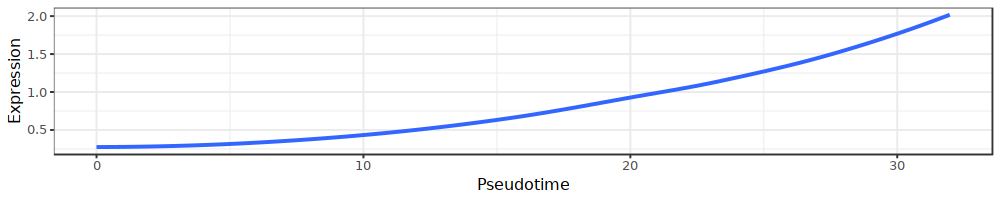

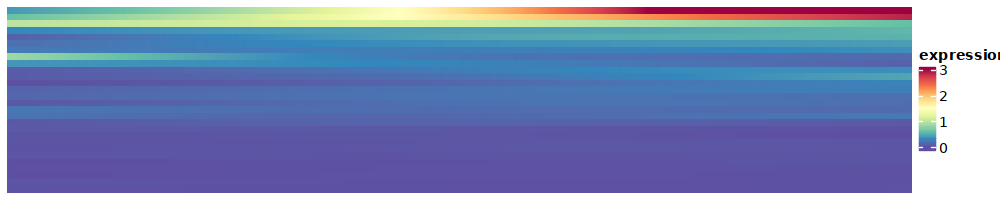

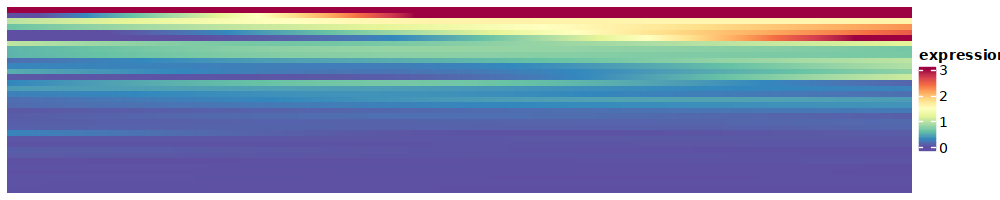

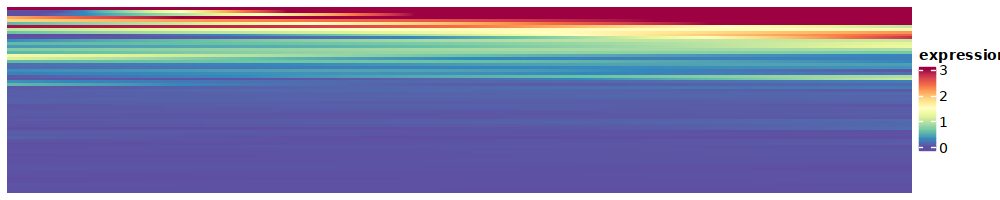

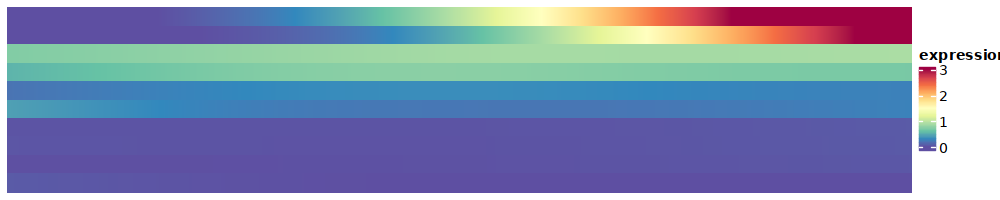

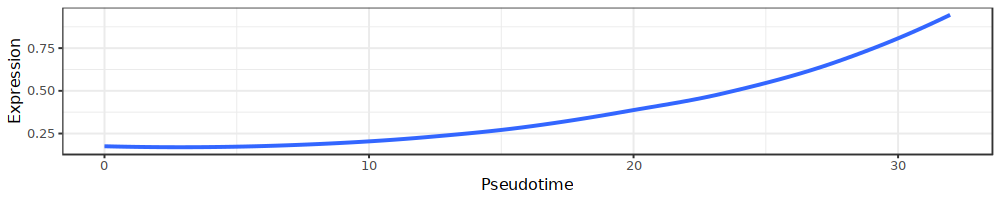

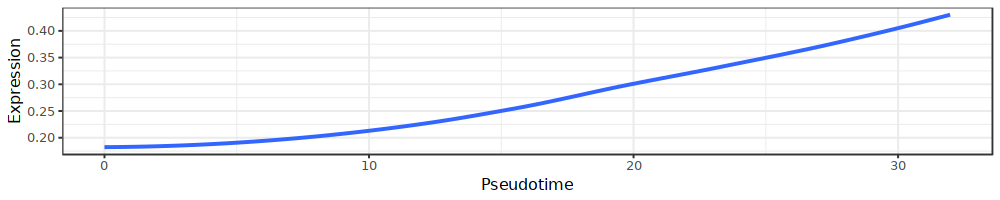

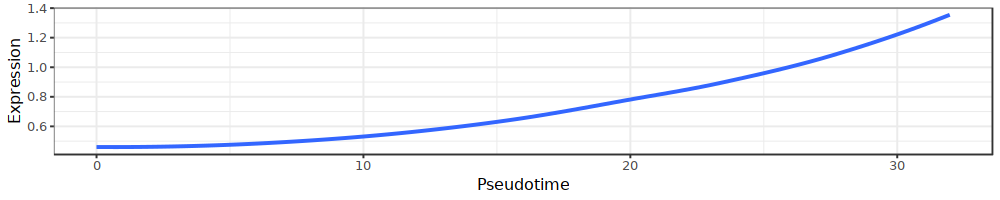

$Ensheathment_of_neurons

$Learning_or_memory

$Synapse_organization

$Myelination


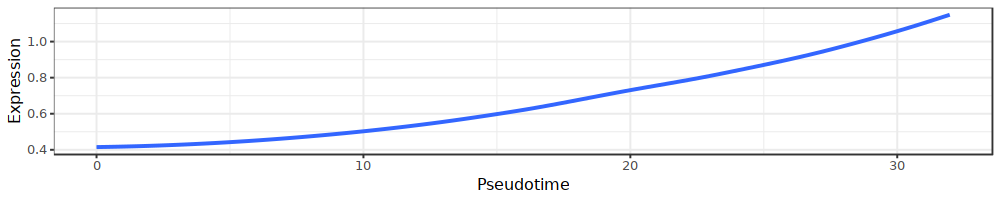

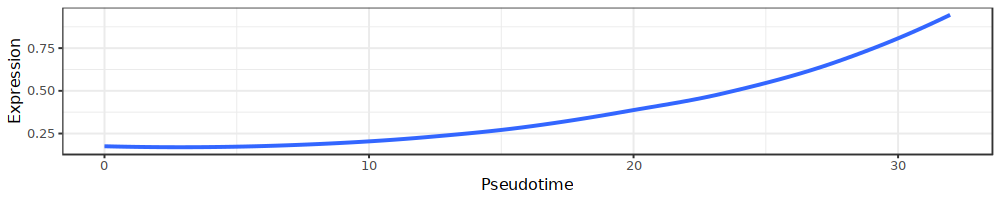

In [459]:
lapply(selected_gene_olf,plot_heatmap_trend,'')
lapply(selected_gene_brain ,plot_heatmap_trend,'')


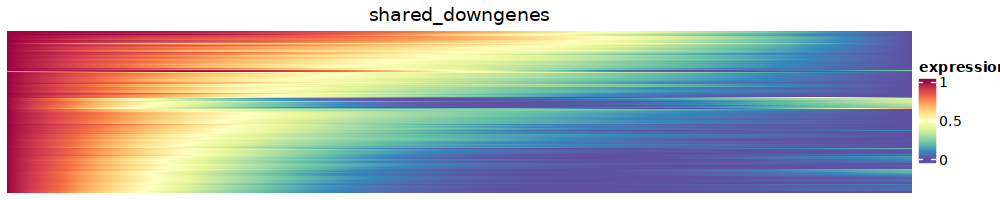

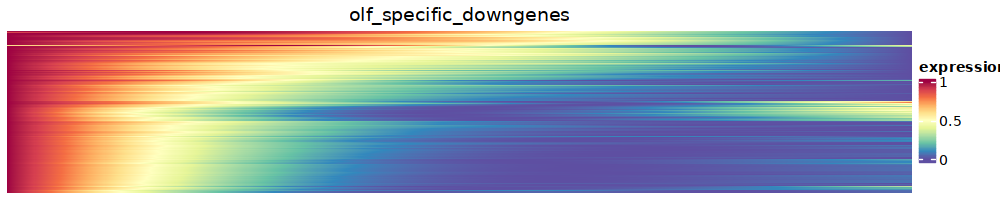

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



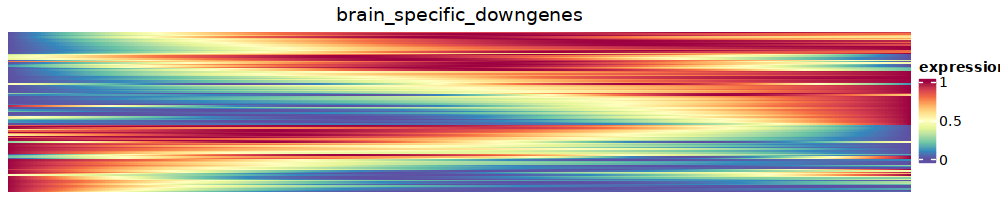

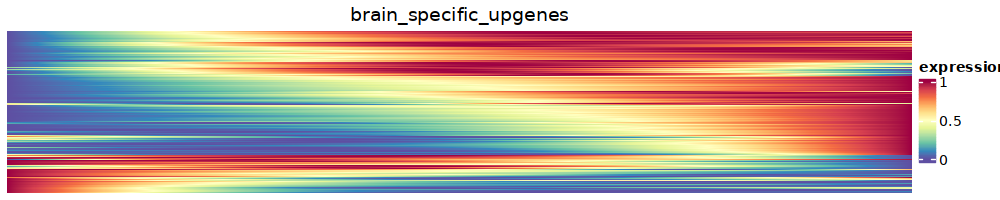

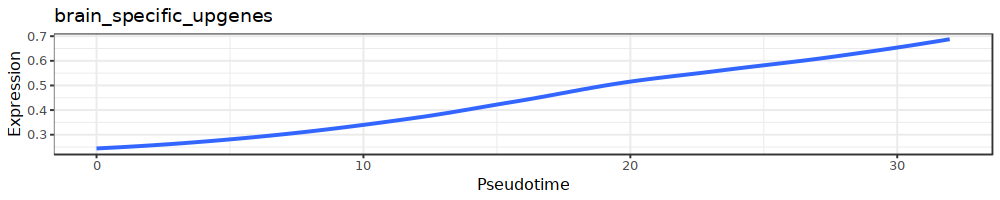

In [299]:
plot_mean_trend(DEGs=DEG_overlap_gene[['down']][['down']],'shared_downgenes')
# plot_mean_trend(DEGs=DEG_overlap_gene[['up']][['up']],'overlap_upgene')
# plot_mean_trend(DEGs=DEG_overlap_gene[['down']][['up']],'overlap_downupgene')
# plot_mean_trend(DEGs=DEG_overlap_gene[['up']][['down']],'overlap_updowngene')

plot_mean_trend(DEGs=unique_olf[['down']],'olf_specific_downgenes')


plot_mean_trend(DEGs=unique_brain[['down']],'brain_specific_downgenes')
plot_mean_trend(DEGs=unique_brain[['up']],'brain_specific_upgenes')
# plot_mean_trend(DEGs=unique_brain[['up']],'brain_specific_upgene')
# plot_mean_trend(DEGs=unique_brain[['trans_up']],'brain_specific_trans_upgene')
# plot_mean_trend(DEGs=unique_brain[['trans_down']],'brain_specific_trans_downgene')

